In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import List, Optional, Union
from typing import Tuple
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm

def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

# Call this at the beginning of your script
set_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
EPOCHS = 500 # Set the total number of epochs you want to train for
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [3]:
df = pd.read_csv("./CICIDS/Friday-Merged-Binary.csv")
df['Attempted Category'] = df['Attempted Category'].replace({-1: 0}) # 0 as BENIGN
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attempted Category
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN,0
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN,0
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN,0
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN,0
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN,0


In [4]:
X = df.drop([' Label', 'Attempted Category'], axis=1)
y = df['Attempted Category']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [6]:
X_train = X_train.loc[:, (X_train >= 0).all()]
X_train = np.log1p(X_train)

X_test = X_test.loc[:, (X_test >= 0).all()]
X_test = np.log1p(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("x_train shape:",X_train_scaled.shape,"| y_train shape:",y_train.shape,"| x_test shape:",X_test_scaled.shape,"| y_test shape:",y_test.shape)

x_train shape: (369259, 69) | y_train shape: (369259,) | x_test shape: (246174, 69) | y_test shape: (246174,)


In [7]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [8]:
class IndexedDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.X = X_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

train_dataset = IndexedDataset(x_train_tensor,y_train_tensor)
test_dataset = IndexedDataset(x_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Initialize per-sample weights (1.0 for all)
sample_weights = torch.ones(len(x_train_tensor), dtype=torch.float32)
sample_weights = sample_weights.to(device)

In [9]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer1 = nn.Linear(num_features, 32)
        self.y0_head = nn.Linear(32, 1)
        self.m_head  = nn.Linear(32, 1)
        self.x0_head = nn.Linear(32, 1)
        self.combine = nn.Linear(3, 3)

    def forward(self, x):
        h = self.layer1(x)
        h = torch.tanh(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = params[:,0:1], params[:,1:2], params[:,2:3]
        
        y = y0 + m * (x - x0)
        return [x, y], [x0, y0, m]

In [10]:
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.layer1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.activation1 = ActivationNet(num_features=128)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.activation2 = ActivationNet(num_features=64)
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.activation3 = ActivationNet(num_features=32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.bn1(self.layer1(x))
        out1, internal_out1 = self.activation1(x)
        
        x = self.bn2(self.layer2(out1[1]))
        out2, internal_out2 = self.activation2(x)

        x = self.bn3(self.layer3(out2[1]))
        out3, internal_out3 = self.activation3(x)

        x = self.output_layer(out3[1])
        return x, [out1, out2, out3], [internal_out1, internal_out2, internal_out3]

In [11]:
# --- File Paths ---
BEST_MODEL_PATH = "./CICIDS/results_mv_1d/best_model_f1.pth"
CHECKPOINT_PATH = "./CICIDS/results_mv_1d/training_checkpoint.pth"
LOGS_PATH = "./CICIDS/results_mv_1d/training_logs.csv"

In [12]:
input_features = X_train_scaled.shape[1]

model = KDD_Model(input_features)
model = model.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=50, min_lr=1e-6
 )

In [13]:
# Checkpoint Loading (Resume Logic)

THRESH = 0.5  # <- your decision threshold
start_epoch = 0
best_f1_score = 0.0
history = []

# Check if a checkpoint file exists
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_PATH}")
    # Load the checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, weights_only=False)
    
    # Restore the state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    # Find the best F1 score from the loaded history to continue tracking
    if history:
        # This gets the 'test_f1' value from each dictionary in the history list
        best_f1_score = max([epoch_data.get('test_f1', 0) for epoch_data in history])
    
    print(f"Resuming from epoch {start_epoch}. Best Test F1 so far: {best_f1_score:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Checkpoint found! Resuming training from ./CICIDS/results_mv_1d/training_checkpoint.pth
Resuming from epoch 500. Best Test F1 so far: 0.9977


In [14]:
def update_sample_weights(
    model: nn.Module,
    data_loader: DataLoader,
    current_weights: torch.Tensor,
    device: torch.device,
    threshold: float = 0.5,
    increase_factor: float = 1.2,
    decrease_factor: float = 0.9,
    min_weight: float = 0.1,
    max_weight: float = 5.0
) -> torch.Tensor:

    model.eval()  # Set model to evaluation mode for consistent predictions
    
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        # Loop through the entire dataset to get predictions
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            all_preds.append(preds.view(-1))
            all_labels.append(labels.view(-1))
            all_indices.append(indices.to(device)) # Keep indices on the same device
            
    # Concatenate all batch results into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_indices = torch.cat(all_indices)

    # Identify incorrect and correct predictions using a boolean mask
    incorrect_mask = (all_preds != all_labels)
    correct_mask = ~incorrect_mask

    # Use the boolean masks to get the global indices of the samples
    incorrect_indices = all_indices[incorrect_mask]
    correct_indices = all_indices[correct_mask]

    # Update weights for the identified samples
    # Note: We update the original 'current_weights' tensor
    current_weights[incorrect_indices] *= increase_factor
    current_weights[correct_indices] *= decrease_factor
    
    # Clamp the weights to a reasonable range and return
    return current_weights.clamp(min=min_weight, max=max_weight)

In [15]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs, _, _ = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [ ]:
# ---------------- Main Training Loop ----------------
for epoch in range(start_epoch, EPOCHS):
    model.train()

    # running stats for TRAIN (weighted loss averaged by total weight)
    total_weighted_loss = 0.0
    total_count = 0.0

    train_all_preds = []
    train_all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for inputs, labels, indices in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1).long()
        indices = indices.to(device)

        # ---- Forward ----
        outputs, _, _ = model(inputs)  # shape [B, 1] or [B]
        logits = outputs.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).long()

        # per-sample loss (assumes BCEWithLogitsLoss(reduction='none'))
        losses = loss_fn(logits, labels.float()).view(-1)

        # weights
        batch_weights = sample_weights[indices]  # shape [B]
        weighted_loss = (losses * batch_weights).mean()

        # ---- Backward ----
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        # ---- Accumulate epoch stats ----
        batch_size = labels.size(0)
        total_weighted_loss += weighted_loss.item() * batch_size
        total_count += batch_size

        train_all_preds.append(preds.detach().cpu())
        train_all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(weighted_loss=total_weighted_loss / total_count)

    # Update weights: increase for misclassified
    sample_weights = update_sample_weights(
        model=model,
        data_loader=train_loader,
        current_weights=sample_weights,
        device=device,
        threshold=THRESH
    )

    # ---- TRAIN epoch metrics (threshold-based) ----
    train_all_preds = torch.cat(train_all_preds).numpy()
    train_all_labels = torch.cat(train_all_labels).numpy()

    train_weighted_loss = total_weighted_loss / total_count
    train_acc = (train_all_preds == train_all_labels).mean()
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(
        train_all_labels, train_all_preds, average='macro', zero_division=0
    )

    # ---- TEST evaluation (single pass, threshold-based) ----
    test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )

    scheduler.step(test_f1)

    # ---- Logging ----
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_weighted_loss:.4f}, Acc(th={THRESH}): {train_acc:.4f}, "
        f"P: {train_p:.4f}, R: {train_r:.4f}, F1: {train_f1:.4f} | "
        f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
        f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
    )

    epoch_data = {
        'epoch': epoch + 1,
        'train_loss': train_weighted_loss,
        'train_accuracy_threshold': train_acc,
        'train_precision': train_p,
        'train_recall': train_r,
        'train_f1': train_f1,
        'test_loss': test_loss,
        'test_accuracy_threshold': test_acc,
        'test_precision': test_p,
        'test_recall': test_r,
        'test_f1': test_f1,
        'threshold': THRESH,
    }
    history.append(epoch_data)
    pd.DataFrame(history).to_csv(LOGS_PATH, index=False)

    # ---- Save the Best Model by Test F1 ----
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with Test F1 Score: {best_f1_score:.4f}")

    # ---- Checkpoint every epoch ----
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

print("="*60)
print("Training finished!")
print(f"Best model saved to: {BEST_MODEL_PATH} (Test F1: {best_f1_score:.4f})")
print(f"Full training logs saved to: {LOGS_PATH}")
print(f"Final checkpoint for resumption saved to: {CHECKPOINT_PATH}")

Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.39it/s, loss=0.0308]


Epoch 1/500 | Train Loss: 0.1927, Acc(th=0.5): 0.9329, P: 0.9361, R: 0.9175, F1: 0.9256 | Test Loss: 0.0308, Acc(th=0.5): 0.9943, P: 0.9941, R: 0.9934, F1: 0.9938
🎉 New best model saved with Test F1 Score: 0.9938


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.32it/s, loss=0.0205]


Epoch 2/500 | Train Loss: 0.0263, Acc(th=0.5): 0.9950, P: 0.9950, R: 0.9940, F1: 0.9945 | Test Loss: 0.0205, Acc(th=0.5): 0.9953, P: 0.9957, R: 0.9941, F1: 0.9949
🎉 New best model saved with Test F1 Score: 0.9949


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.66it/s, loss=0.0154]


Epoch 3/500 | Train Loss: 0.0197, Acc(th=0.5): 0.9953, P: 0.9953, R: 0.9944, F1: 0.9948 | Test Loss: 0.0154, Acc(th=0.5): 0.9955, P: 0.9957, R: 0.9944, F1: 0.9951
🎉 New best model saved with Test F1 Score: 0.9951


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.69it/s, loss=0.014]


Epoch 4/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9962, P: 0.9961, R: 0.9957, F1: 0.9959 | Test Loss: 0.0140, Acc(th=0.5): 0.9966, P: 0.9969, R: 0.9958, F1: 0.9963
🎉 New best model saved with Test F1 Score: 0.9963


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.13it/s, loss=0.0121]


Epoch 5/500 | Train Loss: 0.0170, Acc(th=0.5): 0.9963, P: 0.9961, R: 0.9959, F1: 0.9960 | Test Loss: 0.0121, Acc(th=0.5): 0.9969, P: 0.9973, R: 0.9961, F1: 0.9966
🎉 New best model saved with Test F1 Score: 0.9966


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.70it/s, loss=0.0141]


Epoch 6/500 | Train Loss: 0.0168, Acc(th=0.5): 0.9963, P: 0.9960, R: 0.9961, F1: 0.9960 | Test Loss: 0.0141, Acc(th=0.5): 0.9962, P: 0.9957, R: 0.9959, F1: 0.9958


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.84it/s, loss=0.013]


Epoch 7/500 | Train Loss: 0.0167, Acc(th=0.5): 0.9964, P: 0.9960, R: 0.9961, F1: 0.9960 | Test Loss: 0.0130, Acc(th=0.5): 0.9968, P: 0.9968, R: 0.9962, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.16it/s, loss=0.0129]


Epoch 8/500 | Train Loss: 0.0171, Acc(th=0.5): 0.9963, P: 0.9957, R: 0.9961, F1: 0.9959 | Test Loss: 0.0129, Acc(th=0.5): 0.9967, P: 0.9964, R: 0.9964, F1: 0.9964


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.31it/s, loss=0.0161]


Epoch 9/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9956, P: 0.9949, R: 0.9956, F1: 0.9952 | Test Loss: 0.0161, Acc(th=0.5): 0.9966, P: 0.9967, R: 0.9960, F1: 0.9963


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.69it/s, loss=0.0167]


Epoch 10/500 | Train Loss: 0.0180, Acc(th=0.5): 0.9946, P: 0.9934, R: 0.9950, F1: 0.9942 | Test Loss: 0.0167, Acc(th=0.5): 0.9964, P: 0.9962, R: 0.9959, F1: 0.9961


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.10it/s, loss=0.0172]


Epoch 11/500 | Train Loss: 0.0173, Acc(th=0.5): 0.9940, P: 0.9924, R: 0.9946, F1: 0.9935 | Test Loss: 0.0172, Acc(th=0.5): 0.9964, P: 0.9959, R: 0.9964, F1: 0.9961


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.57it/s, loss=0.0193]


Epoch 12/500 | Train Loss: 0.0168, Acc(th=0.5): 0.9941, P: 0.9927, R: 0.9946, F1: 0.9936 | Test Loss: 0.0193, Acc(th=0.5): 0.9962, P: 0.9955, R: 0.9962, F1: 0.9959


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.09it/s, loss=0.0183]


Epoch 13/500 | Train Loss: 0.0167, Acc(th=0.5): 0.9921, P: 0.9900, R: 0.9930, F1: 0.9915 | Test Loss: 0.0183, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9969
🎉 New best model saved with Test F1 Score: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.23it/s, loss=0.0187]


Epoch 14/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9912, P: 0.9887, R: 0.9923, F1: 0.9905 | Test Loss: 0.0187, Acc(th=0.5): 0.9962, P: 0.9957, R: 0.9961, F1: 0.9959


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.96it/s, loss=0.0188]


Epoch 15/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9915, P: 0.9892, R: 0.9925, F1: 0.9908 | Test Loss: 0.0188, Acc(th=0.5): 0.9974, P: 0.9979, R: 0.9965, F1: 0.9972
🎉 New best model saved with Test F1 Score: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.95it/s, loss=0.0209]


Epoch 16/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9889, P: 0.9856, R: 0.9905, F1: 0.9880 | Test Loss: 0.0209, Acc(th=0.5): 0.9964, P: 0.9958, R: 0.9964, F1: 0.9961


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.48it/s, loss=0.0234]


Epoch 17/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9865, P: 0.9825, R: 0.9887, F1: 0.9855 | Test Loss: 0.0234, Acc(th=0.5): 0.9808, P: 0.9751, R: 0.9843, F1: 0.9794


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.19it/s, loss=0.017]


Epoch 18/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9901, P: 0.9872, R: 0.9914, F1: 0.9893 | Test Loss: 0.0170, Acc(th=0.5): 0.9975, P: 0.9979, R: 0.9967, F1: 0.9973
🎉 New best model saved with Test F1 Score: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.33it/s, loss=0.0248]


Epoch 19/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9857, P: 0.9812, R: 0.9882, F1: 0.9845 | Test Loss: 0.0248, Acc(th=0.5): 0.9826, P: 0.9770, R: 0.9862, F1: 0.9813


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.65it/s, loss=0.0201]


Epoch 20/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9912, P: 0.9888, R: 0.9923, F1: 0.9905 | Test Loss: 0.0201, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9969, F1: 0.9974
🎉 New best model saved with Test F1 Score: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.50it/s, loss=0.0219]


Epoch 21/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9865, P: 0.9822, R: 0.9890, F1: 0.9854 | Test Loss: 0.0219, Acc(th=0.5): 0.9969, P: 0.9969, R: 0.9962, F1: 0.9966


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.04it/s, loss=0.0207]


Epoch 22/500 | Train Loss: 0.0138, Acc(th=0.5): 0.9837, P: 0.9786, R: 0.9868, F1: 0.9824 | Test Loss: 0.0207, Acc(th=0.5): 0.9968, P: 0.9964, R: 0.9967, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.86it/s, loss=0.0323]


Epoch 23/500 | Train Loss: 0.0130, Acc(th=0.5): 0.9817, P: 0.9760, R: 0.9853, F1: 0.9803 | Test Loss: 0.0323, Acc(th=0.5): 0.9761, P: 0.9691, R: 0.9807, F1: 0.9743


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.15it/s, loss=0.0298]


Epoch 24/500 | Train Loss: 0.0133, Acc(th=0.5): 0.9864, P: 0.9821, R: 0.9889, F1: 0.9853 | Test Loss: 0.0298, Acc(th=0.5): 0.9765, P: 0.9696, R: 0.9811, F1: 0.9748


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.81it/s, loss=0.0209]


Epoch 25/500 | Train Loss: 0.0135, Acc(th=0.5): 0.9913, P: 0.9887, R: 0.9925, F1: 0.9905 | Test Loss: 0.0209, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9968


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.04it/s, loss=0.0282]


Epoch 26/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9874, P: 0.9835, R: 0.9897, F1: 0.9864 | Test Loss: 0.0282, Acc(th=0.5): 0.9798, P: 0.9734, R: 0.9841, F1: 0.9783


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 54.82it/s, loss=0.0198]


Epoch 27/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9909, P: 0.9883, R: 0.9921, F1: 0.9902 | Test Loss: 0.0198, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975
🎉 New best model saved with Test F1 Score: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.04it/s, loss=0.0245]


Epoch 28/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9876, P: 0.9837, R: 0.9898, F1: 0.9866 | Test Loss: 0.0245, Acc(th=0.5): 0.9934, P: 0.9915, R: 0.9941, F1: 0.9928


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.19it/s, loss=0.0225]


Epoch 29/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9857, P: 0.9813, R: 0.9883, F1: 0.9846 | Test Loss: 0.0225, Acc(th=0.5): 0.9976, P: 0.9980, R: 0.9969, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.18it/s, loss=0.0293]


Epoch 30/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9856, P: 0.9810, R: 0.9883, F1: 0.9844 | Test Loss: 0.0293, Acc(th=0.5): 0.9784, P: 0.9717, R: 0.9831, F1: 0.9768


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.71it/s, loss=0.0223]


Epoch 31/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9887, P: 0.9853, R: 0.9904, F1: 0.9877 | Test Loss: 0.0223, Acc(th=0.5): 0.9940, P: 0.9924, R: 0.9947, F1: 0.9935


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.07it/s, loss=0.0206]


Epoch 32/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9873, P: 0.9836, R: 0.9893, F1: 0.9863 | Test Loss: 0.0206, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9969, F1: 0.9975
🎉 New best model saved with Test F1 Score: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.47it/s, loss=0.0251]


Epoch 33/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9849, P: 0.9803, R: 0.9876, F1: 0.9837 | Test Loss: 0.0251, Acc(th=0.5): 0.9796, P: 0.9735, R: 0.9834, F1: 0.9781


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.65it/s, loss=0.0208]


Epoch 34/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9889, P: 0.9855, R: 0.9908, F1: 0.9880 | Test Loss: 0.0208, Acc(th=0.5): 0.9974, P: 0.9978, R: 0.9966, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.35it/s, loss=0.0207]


Epoch 35/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9857, P: 0.9812, R: 0.9884, F1: 0.9846 | Test Loss: 0.0207, Acc(th=0.5): 0.9968, P: 0.9964, R: 0.9967, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.07it/s, loss=0.0261]


Epoch 36/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9838, P: 0.9787, R: 0.9869, F1: 0.9825 | Test Loss: 0.0261, Acc(th=0.5): 0.9823, P: 0.9769, R: 0.9856, F1: 0.9810


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.20it/s, loss=0.0235]


Epoch 37/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9887, P: 0.9852, R: 0.9906, F1: 0.9878 | Test Loss: 0.0235, Acc(th=0.5): 0.9873, P: 0.9831, R: 0.9898, F1: 0.9863


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.44it/s, loss=0.0199]


Epoch 38/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9902, P: 0.9873, R: 0.9915, F1: 0.9894 | Test Loss: 0.0199, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9970, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.03it/s, loss=0.0264]


Epoch 39/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9874, P: 0.9837, R: 0.9894, F1: 0.9864 | Test Loss: 0.0264, Acc(th=0.5): 0.9795, P: 0.9733, R: 0.9834, F1: 0.9780


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.57it/s, loss=0.017]


Epoch 40/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9910, P: 0.9884, R: 0.9922, F1: 0.9902 | Test Loss: 0.0170, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9969, F1: 0.9976
🎉 New best model saved with Test F1 Score: 0.9976


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.96it/s, loss=0.021]


Epoch 41/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9872, P: 0.9832, R: 0.9895, F1: 0.9862 | Test Loss: 0.0210, Acc(th=0.5): 0.9968, P: 0.9963, R: 0.9967, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.28it/s, loss=0.0212]


Epoch 42/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9870, P: 0.9831, R: 0.9892, F1: 0.9860 | Test Loss: 0.0212, Acc(th=0.5): 0.9925, P: 0.9903, R: 0.9935, F1: 0.9919


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.33it/s, loss=0.0194]


Epoch 43/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9863, P: 0.9821, R: 0.9886, F1: 0.9852 | Test Loss: 0.0194, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.17it/s, loss=0.0239]


Epoch 44/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9842, P: 0.9794, R: 0.9871, F1: 0.9830 | Test Loss: 0.0239, Acc(th=0.5): 0.9840, P: 0.9791, R: 0.9868, F1: 0.9827


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.89it/s, loss=0.0198]


Epoch 45/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9890, P: 0.9856, R: 0.9907, F1: 0.9881 | Test Loss: 0.0198, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.71it/s, loss=0.0269]


Epoch 46/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9847, P: 0.9800, R: 0.9873, F1: 0.9835 | Test Loss: 0.0269, Acc(th=0.5): 0.9796, P: 0.9734, R: 0.9835, F1: 0.9780


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.35it/s, loss=0.02]


Epoch 47/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9902, P: 0.9873, R: 0.9916, F1: 0.9894 | Test Loss: 0.0200, Acc(th=0.5): 0.9972, P: 0.9973, R: 0.9965, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.41it/s, loss=0.0218]


Epoch 48/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9862, P: 0.9819, R: 0.9887, F1: 0.9851 | Test Loss: 0.0218, Acc(th=0.5): 0.9921, P: 0.9899, R: 0.9932, F1: 0.9915


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.94it/s, loss=0.0178]


Epoch 49/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9879, P: 0.9842, R: 0.9899, F1: 0.9869 | Test Loss: 0.0178, Acc(th=0.5): 0.9977, P: 0.9980, R: 0.9970, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.15it/s, loss=0.0332]


Epoch 50/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9853, P: 0.9807, R: 0.9880, F1: 0.9841 | Test Loss: 0.0332, Acc(th=0.5): 0.9759, P: 0.9689, R: 0.9807, F1: 0.9742


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.80it/s, loss=0.0228]


Epoch 51/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9911, P: 0.9885, R: 0.9924, F1: 0.9904 | Test Loss: 0.0228, Acc(th=0.5): 0.9899, P: 0.9867, R: 0.9916, F1: 0.9891


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.12it/s, loss=0.0192]


Epoch 52/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9923, P: 0.9903, R: 0.9931, F1: 0.9916 | Test Loss: 0.0192, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9968, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.97it/s, loss=0.0255]


Epoch 53/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9882, P: 0.9845, R: 0.9902, F1: 0.9872 | Test Loss: 0.0255, Acc(th=0.5): 0.9821, P: 0.9767, R: 0.9854, F1: 0.9808


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.80it/s, loss=0.0243]


Epoch 54/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9927, P: 0.9906, R: 0.9936, F1: 0.9920 | Test Loss: 0.0243, Acc(th=0.5): 0.9837, P: 0.9784, R: 0.9870, F1: 0.9824


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.53it/s, loss=0.0229]


Epoch 55/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9952, P: 0.9943, R: 0.9952, F1: 0.9948 | Test Loss: 0.0229, Acc(th=0.5): 0.9902, P: 0.9872, R: 0.9918, F1: 0.9894


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.13it/s, loss=0.0172]


Epoch 56/500 | Train Loss: 0.0162, Acc(th=0.5): 0.9956, P: 0.9951, R: 0.9954, F1: 0.9953 | Test Loss: 0.0172, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.60it/s, loss=0.0183]


Epoch 57/500 | Train Loss: 0.0163, Acc(th=0.5): 0.9932, P: 0.9916, R: 0.9937, F1: 0.9927 | Test Loss: 0.0183, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9968, F1: 0.9968


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.36it/s, loss=0.0191]


Epoch 58/500 | Train Loss: 0.0163, Acc(th=0.5): 0.9922, P: 0.9902, R: 0.9929, F1: 0.9915 | Test Loss: 0.0191, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.60it/s, loss=0.0205]


Epoch 59/500 | Train Loss: 0.0160, Acc(th=0.5): 0.9892, P: 0.9859, R: 0.9908, F1: 0.9883 | Test Loss: 0.0205, Acc(th=0.5): 0.9972, P: 0.9969, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.56it/s, loss=0.0299]


Epoch 60/500 | Train Loss: 0.0156, Acc(th=0.5): 0.9861, P: 0.9819, R: 0.9883, F1: 0.9849 | Test Loss: 0.0299, Acc(th=0.5): 0.9765, P: 0.9695, R: 0.9811, F1: 0.9747


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.58it/s, loss=0.0182]


Epoch 61/500 | Train Loss: 0.0161, Acc(th=0.5): 0.9928, P: 0.9910, R: 0.9934, F1: 0.9922 | Test Loss: 0.0182, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.83it/s, loss=0.0255]


Epoch 62/500 | Train Loss: 0.0160, Acc(th=0.5): 0.9905, P: 0.9880, R: 0.9916, F1: 0.9897 | Test Loss: 0.0255, Acc(th=0.5): 0.9777, P: 0.9711, R: 0.9819, F1: 0.9760


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.24it/s, loss=0.0155]


Epoch 63/500 | Train Loss: 0.0163, Acc(th=0.5): 0.9951, P: 0.9942, R: 0.9951, F1: 0.9947 | Test Loss: 0.0155, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9968, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.10it/s, loss=0.0213]


Epoch 64/500 | Train Loss: 0.0162, Acc(th=0.5): 0.9910, P: 0.9884, R: 0.9921, F1: 0.9902 | Test Loss: 0.0213, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.94it/s, loss=0.019]


Epoch 65/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9888, P: 0.9854, R: 0.9906, F1: 0.9879 | Test Loss: 0.0190, Acc(th=0.5): 0.9971, P: 0.9969, R: 0.9969, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.10it/s, loss=0.0246]


Epoch 66/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9859, P: 0.9817, R: 0.9882, F1: 0.9848 | Test Loss: 0.0246, Acc(th=0.5): 0.9796, P: 0.9734, R: 0.9835, F1: 0.9781


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.96it/s, loss=0.0208]


Epoch 67/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9911, P: 0.9886, R: 0.9923, F1: 0.9904 | Test Loss: 0.0208, Acc(th=0.5): 0.9969, P: 0.9965, R: 0.9968, F1: 0.9966


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.77it/s, loss=0.0243]


Epoch 68/500 | Train Loss: 0.0157, Acc(th=0.5): 0.9890, P: 0.9859, R: 0.9905, F1: 0.9881 | Test Loss: 0.0243, Acc(th=0.5): 0.9809, P: 0.9749, R: 0.9849, F1: 0.9795


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.03it/s, loss=0.0205]


Epoch 69/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9941, P: 0.9929, R: 0.9942, F1: 0.9935 | Test Loss: 0.0205, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976
🎉 New best model saved with Test F1 Score: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.42it/s, loss=0.0188]


Epoch 70/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9903, P: 0.9876, R: 0.9915, F1: 0.9895 | Test Loss: 0.0188, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9968, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.98it/s, loss=0.0217]


Epoch 71/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9871, P: 0.9832, R: 0.9891, F1: 0.9860 | Test Loss: 0.0217, Acc(th=0.5): 0.9945, P: 0.9931, R: 0.9950, F1: 0.9940


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.24it/s, loss=0.024]


Epoch 72/500 | Train Loss: 0.0156, Acc(th=0.5): 0.9876, P: 0.9840, R: 0.9895, F1: 0.9866 | Test Loss: 0.0240, Acc(th=0.5): 0.9799, P: 0.9739, R: 0.9837, F1: 0.9784


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.30it/s, loss=0.0202]


Epoch 73/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9947, P: 0.9936, R: 0.9948, F1: 0.9942 | Test Loss: 0.0202, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.54it/s, loss=0.0206]


Epoch 74/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9897, P: 0.9867, R: 0.9912, F1: 0.9888 | Test Loss: 0.0206, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.78it/s, loss=0.0214]


Epoch 75/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9856, P: 0.9811, R: 0.9883, F1: 0.9845 | Test Loss: 0.0214, Acc(th=0.5): 0.9968, P: 0.9963, R: 0.9966, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.16it/s, loss=0.0262]


Epoch 76/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9845, P: 0.9798, R: 0.9872, F1: 0.9833 | Test Loss: 0.0262, Acc(th=0.5): 0.9770, P: 0.9700, R: 0.9817, F1: 0.9753


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.94it/s, loss=0.022]


Epoch 77/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9922, P: 0.9902, R: 0.9929, F1: 0.9915 | Test Loss: 0.0220, Acc(th=0.5): 0.9926, P: 0.9908, R: 0.9931, F1: 0.9919


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.40it/s, loss=0.0217]


Epoch 78/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9923, P: 0.9902, R: 0.9930, F1: 0.9916 | Test Loss: 0.0217, Acc(th=0.5): 0.9967, P: 0.9962, R: 0.9966, F1: 0.9964


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.28it/s, loss=0.0202]


Epoch 79/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9876, P: 0.9840, R: 0.9894, F1: 0.9866 | Test Loss: 0.0202, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.39it/s, loss=0.0209]


Epoch 80/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9869, P: 0.9828, R: 0.9891, F1: 0.9858 | Test Loss: 0.0209, Acc(th=0.5): 0.9967, P: 0.9962, R: 0.9966, F1: 0.9964


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.08it/s, loss=0.0268]


Epoch 81/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9855, P: 0.9812, R: 0.9879, F1: 0.9844 | Test Loss: 0.0268, Acc(th=0.5): 0.9780, P: 0.9715, R: 0.9823, F1: 0.9764


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.52it/s, loss=0.0192]


Epoch 82/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9924, P: 0.9905, R: 0.9931, F1: 0.9918 | Test Loss: 0.0192, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9969, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.96it/s, loss=0.0278]


Epoch 83/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9866, P: 0.9825, R: 0.9888, F1: 0.9855 | Test Loss: 0.0278, Acc(th=0.5): 0.9771, P: 0.9703, R: 0.9816, F1: 0.9754


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.42it/s, loss=0.0187]


Epoch 84/500 | Train Loss: 0.0157, Acc(th=0.5): 0.9914, P: 0.9892, R: 0.9923, F1: 0.9907 | Test Loss: 0.0187, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.28it/s, loss=0.0219]


Epoch 85/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9885, P: 0.9850, R: 0.9903, F1: 0.9875 | Test Loss: 0.0219, Acc(th=0.5): 0.9956, P: 0.9947, R: 0.9958, F1: 0.9953


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.99it/s, loss=0.0224]


Epoch 86/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9874, P: 0.9837, R: 0.9893, F1: 0.9864 | Test Loss: 0.0224, Acc(th=0.5): 0.9873, P: 0.9836, R: 0.9893, F1: 0.9863


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.56it/s, loss=0.0213]


Epoch 87/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9900, P: 0.9871, R: 0.9913, F1: 0.9891 | Test Loss: 0.0213, Acc(th=0.5): 0.9948, P: 0.9939, R: 0.9949, F1: 0.9944


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.54it/s, loss=0.0231]


Epoch 88/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9912, P: 0.9887, R: 0.9923, F1: 0.9905 | Test Loss: 0.0231, Acc(th=0.5): 0.9875, P: 0.9838, R: 0.9895, F1: 0.9865


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.46it/s, loss=0.0219]


Epoch 89/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9946, P: 0.9934, R: 0.9949, F1: 0.9941 | Test Loss: 0.0219, Acc(th=0.5): 0.9968, P: 0.9964, R: 0.9966, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.12it/s, loss=0.0196]


Epoch 90/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9922, P: 0.9902, R: 0.9929, F1: 0.9915 | Test Loss: 0.0196, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9974


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.29it/s, loss=0.023]


Epoch 91/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9879, P: 0.9843, R: 0.9897, F1: 0.9869 | Test Loss: 0.0230, Acc(th=0.5): 0.9813, P: 0.9757, R: 0.9847, F1: 0.9799


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.19it/s, loss=0.0196]


Epoch 92/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9964, P: 0.9960, R: 0.9962, F1: 0.9961 | Test Loss: 0.0196, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.88it/s, loss=0.0214]


Epoch 93/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9927, P: 0.9910, R: 0.9933, F1: 0.9921 | Test Loss: 0.0214, Acc(th=0.5): 0.9972, P: 0.9974, R: 0.9965, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.40it/s, loss=0.0184]


Epoch 94/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9900, P: 0.9870, R: 0.9914, F1: 0.9892 | Test Loss: 0.0184, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.29it/s, loss=0.0241]


Epoch 95/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9884, P: 0.9848, R: 0.9904, F1: 0.9875 | Test Loss: 0.0241, Acc(th=0.5): 0.9779, P: 0.9710, R: 0.9826, F1: 0.9762


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.19it/s, loss=0.0177]


Epoch 96/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9953, P: 0.9945, R: 0.9953, F1: 0.9949 | Test Loss: 0.0177, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9969, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.35it/s, loss=0.0178]


Epoch 97/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9901, P: 0.9872, R: 0.9916, F1: 0.9893 | Test Loss: 0.0178, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9969, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.64it/s, loss=0.0252]


Epoch 98/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9877, P: 0.9840, R: 0.9895, F1: 0.9867 | Test Loss: 0.0252, Acc(th=0.5): 0.9778, P: 0.9712, R: 0.9822, F1: 0.9762


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.53it/s, loss=0.0212]


Epoch 99/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9948, P: 0.9938, R: 0.9950, F1: 0.9944 | Test Loss: 0.0212, Acc(th=0.5): 0.9973, P: 0.9976, R: 0.9966, F1: 0.9971


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.05it/s, loss=0.019]


Epoch 100/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9888, P: 0.9854, R: 0.9906, F1: 0.9879 | Test Loss: 0.0190, Acc(th=0.5): 0.9973, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.09it/s, loss=0.024]


Epoch 101/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9873, P: 0.9835, R: 0.9893, F1: 0.9863 | Test Loss: 0.0240, Acc(th=0.5): 0.9790, P: 0.9728, R: 0.9831, F1: 0.9775


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.72it/s, loss=0.0189]


Epoch 102/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9946, P: 0.9935, R: 0.9948, F1: 0.9942 | Test Loss: 0.0189, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976
🎉 New best model saved with Test F1 Score: 0.9976


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.10it/s, loss=0.021]


Epoch 103/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9883, P: 0.9846, R: 0.9903, F1: 0.9873 | Test Loss: 0.0210, Acc(th=0.5): 0.9952, P: 0.9941, R: 0.9956, F1: 0.9948


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.14it/s, loss=0.026]


Epoch 104/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9909, P: 0.9883, R: 0.9921, F1: 0.9902 | Test Loss: 0.0260, Acc(th=0.5): 0.9766, P: 0.9696, R: 0.9812, F1: 0.9749


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.74it/s, loss=0.018]


Epoch 105/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9935, P: 0.9919, R: 0.9940, F1: 0.9929 | Test Loss: 0.0180, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.53it/s, loss=0.0231]


Epoch 106/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9923, P: 0.9902, R: 0.9933, F1: 0.9917 | Test Loss: 0.0231, Acc(th=0.5): 0.9804, P: 0.9742, R: 0.9846, F1: 0.9790


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.27it/s, loss=0.017]


Epoch 107/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9963, P: 0.9959, R: 0.9960, F1: 0.9959 | Test Loss: 0.0170, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976
🎉 New best model saved with Test F1 Score: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.24it/s, loss=0.0238]


Epoch 108/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9921, P: 0.9898, R: 0.9932, F1: 0.9915 | Test Loss: 0.0238, Acc(th=0.5): 0.9786, P: 0.9719, R: 0.9832, F1: 0.9771


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.32it/s, loss=0.0195]


Epoch 109/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9971, P: 0.9972, R: 0.9965, F1: 0.9969 | Test Loss: 0.0195, Acc(th=0.5): 0.9974, P: 0.9977, R: 0.9966, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.03it/s, loss=0.0194]


Epoch 110/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9941, P: 0.9927, R: 0.9944, F1: 0.9936 | Test Loss: 0.0194, Acc(th=0.5): 0.9973, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.22it/s, loss=0.0202]


Epoch 111/500 | Train Loss: 0.0156, Acc(th=0.5): 0.9925, P: 0.9907, R: 0.9932, F1: 0.9919 | Test Loss: 0.0202, Acc(th=0.5): 0.9976, P: 0.9980, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.10it/s, loss=0.0226]


Epoch 112/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9897, P: 0.9866, R: 0.9911, F1: 0.9888 | Test Loss: 0.0226, Acc(th=0.5): 0.9824, P: 0.9768, R: 0.9861, F1: 0.9811


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.12it/s, loss=0.0233]


Epoch 113/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9953, P: 0.9947, R: 0.9952, F1: 0.9949 | Test Loss: 0.0233, Acc(th=0.5): 0.9788, P: 0.9725, R: 0.9829, F1: 0.9773


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.14it/s, loss=0.0142]


Epoch 114/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9966, P: 0.9964, R: 0.9963, F1: 0.9963 | Test Loss: 0.0142, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.33it/s, loss=0.0195]


Epoch 115/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9944, P: 0.9931, R: 0.9946, F1: 0.9939 | Test Loss: 0.0195, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.52it/s, loss=0.0202]


Epoch 116/500 | Train Loss: 0.0156, Acc(th=0.5): 0.9942, P: 0.9931, R: 0.9944, F1: 0.9937 | Test Loss: 0.0202, Acc(th=0.5): 0.9977, P: 0.9980, R: 0.9969, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.30it/s, loss=0.0196]


Epoch 117/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9895, P: 0.9865, R: 0.9910, F1: 0.9887 | Test Loss: 0.0196, Acc(th=0.5): 0.9975, P: 0.9978, R: 0.9967, F1: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.00it/s, loss=0.0217]


Epoch 118/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9875, P: 0.9837, R: 0.9896, F1: 0.9865 | Test Loss: 0.0217, Acc(th=0.5): 0.9877, P: 0.9836, R: 0.9901, F1: 0.9867


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.60it/s, loss=0.0188]


Epoch 119/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9938, P: 0.9925, R: 0.9941, F1: 0.9933 | Test Loss: 0.0188, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.30it/s, loss=0.0209]


Epoch 120/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9899, P: 0.9870, R: 0.9914, F1: 0.9891 | Test Loss: 0.0209, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.63it/s, loss=0.0215]


Epoch 121/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9863, P: 0.9822, R: 0.9885, F1: 0.9852 | Test Loss: 0.0215, Acc(th=0.5): 0.9941, P: 0.9929, R: 0.9944, F1: 0.9936


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.00it/s, loss=0.0254]


Epoch 122/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9895, P: 0.9864, R: 0.9909, F1: 0.9886 | Test Loss: 0.0254, Acc(th=0.5): 0.9769, P: 0.9701, R: 0.9814, F1: 0.9752


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.34it/s, loss=0.0164]


Epoch 123/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9953, P: 0.9944, R: 0.9953, F1: 0.9949 | Test Loss: 0.0164, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.21it/s, loss=0.0177]


Epoch 124/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9907, P: 0.9879, R: 0.9920, F1: 0.9899 | Test Loss: 0.0177, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.91it/s, loss=0.0207]


Epoch 125/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9887, P: 0.9854, R: 0.9904, F1: 0.9878 | Test Loss: 0.0207, Acc(th=0.5): 0.9894, P: 0.9865, R: 0.9908, F1: 0.9886


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 54.82it/s, loss=0.0222]


Epoch 126/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9925, P: 0.9904, R: 0.9934, F1: 0.9919 | Test Loss: 0.0222, Acc(th=0.5): 0.9839, P: 0.9790, R: 0.9868, F1: 0.9826


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.07it/s, loss=0.0167]


Epoch 127/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9964, P: 0.9959, R: 0.9963, F1: 0.9961 | Test Loss: 0.0167, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.94it/s, loss=0.021]


Epoch 128/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9925, P: 0.9907, R: 0.9931, F1: 0.9918 | Test Loss: 0.0210, Acc(th=0.5): 0.9972, P: 0.9974, R: 0.9965, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.70it/s, loss=0.0213]


Epoch 129/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9904, P: 0.9876, R: 0.9916, F1: 0.9896 | Test Loss: 0.0213, Acc(th=0.5): 0.9938, P: 0.9920, R: 0.9945, F1: 0.9932


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.46it/s, loss=0.0215]


Epoch 130/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9939, P: 0.9925, R: 0.9942, F1: 0.9933 | Test Loss: 0.0215, Acc(th=0.5): 0.9877, P: 0.9841, R: 0.9896, F1: 0.9867


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.62it/s, loss=0.0194]


Epoch 131/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9946, P: 0.9934, R: 0.9948, F1: 0.9941 | Test Loss: 0.0194, Acc(th=0.5): 0.9972, P: 0.9974, R: 0.9965, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.73it/s, loss=0.0206]


Epoch 132/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9935, P: 0.9917, R: 0.9942, F1: 0.9929 | Test Loss: 0.0206, Acc(th=0.5): 0.9964, P: 0.9957, R: 0.9965, F1: 0.9961


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.35it/s, loss=0.0202]


Epoch 133/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9933, P: 0.9918, R: 0.9937, F1: 0.9927 | Test Loss: 0.0202, Acc(th=0.5): 0.9970, P: 0.9971, R: 0.9964, F1: 0.9967


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.46it/s, loss=0.0226]


Epoch 134/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9892, P: 0.9860, R: 0.9908, F1: 0.9883 | Test Loss: 0.0226, Acc(th=0.5): 0.9802, P: 0.9740, R: 0.9844, F1: 0.9788


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.38it/s, loss=0.0156]


Epoch 135/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9956, P: 0.9949, R: 0.9954, F1: 0.9952 | Test Loss: 0.0156, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.71it/s, loss=0.0208]


Epoch 136/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9930, P: 0.9912, R: 0.9936, F1: 0.9924 | Test Loss: 0.0208, Acc(th=0.5): 0.9974, P: 0.9977, R: 0.9967, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.89it/s, loss=0.0184]


Epoch 137/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9890, P: 0.9857, R: 0.9908, F1: 0.9881 | Test Loss: 0.0184, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 54.90it/s, loss=0.0176]


Epoch 138/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9866, P: 0.9825, R: 0.9888, F1: 0.9855 | Test Loss: 0.0176, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.92it/s, loss=0.0196]


Epoch 139/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9858, P: 0.9814, R: 0.9882, F1: 0.9846 | Test Loss: 0.0196, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9969, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.68it/s, loss=0.0223]


Epoch 140/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9839, P: 0.9789, R: 0.9870, F1: 0.9827 | Test Loss: 0.0223, Acc(th=0.5): 0.9826, P: 0.9773, R: 0.9858, F1: 0.9813


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.12it/s, loss=0.0174]


Epoch 141/500 | Train Loss: 0.0138, Acc(th=0.5): 0.9890, P: 0.9856, R: 0.9909, F1: 0.9881 | Test Loss: 0.0174, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.62it/s, loss=0.0227]


Epoch 142/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9851, P: 0.9806, R: 0.9877, F1: 0.9839 | Test Loss: 0.0227, Acc(th=0.5): 0.9816, P: 0.9759, R: 0.9850, F1: 0.9801


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.87it/s, loss=0.0207]


Epoch 143/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9946, P: 0.9933, R: 0.9950, F1: 0.9942 | Test Loss: 0.0207, Acc(th=0.5): 0.9925, P: 0.9903, R: 0.9936, F1: 0.9919


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.50it/s, loss=0.0187]


Epoch 144/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9929, P: 0.9912, R: 0.9935, F1: 0.9923 | Test Loss: 0.0187, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.97it/s, loss=0.0233]


Epoch 145/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9900, P: 0.9871, R: 0.9914, F1: 0.9892 | Test Loss: 0.0233, Acc(th=0.5): 0.9800, P: 0.9737, R: 0.9843, F1: 0.9785


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.18it/s, loss=0.0189]


Epoch 146/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9959, P: 0.9954, R: 0.9956, F1: 0.9955 | Test Loss: 0.0189, Acc(th=0.5): 0.9975, P: 0.9978, R: 0.9967, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.85it/s, loss=0.0199]


Epoch 147/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9915, P: 0.9892, R: 0.9924, F1: 0.9908 | Test Loss: 0.0199, Acc(th=0.5): 0.9970, P: 0.9970, R: 0.9965, F1: 0.9967


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.60it/s, loss=0.0178]


Epoch 148/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9891, P: 0.9858, R: 0.9909, F1: 0.9882 | Test Loss: 0.0178, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.79it/s, loss=0.0216]


Epoch 149/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9855, P: 0.9808, R: 0.9883, F1: 0.9843 | Test Loss: 0.0216, Acc(th=0.5): 0.9845, P: 0.9795, R: 0.9877, F1: 0.9833


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.00it/s, loss=0.0196]


Epoch 150/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9936, P: 0.9921, R: 0.9939, F1: 0.9930 | Test Loss: 0.0196, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.98it/s, loss=0.022]


Epoch 151/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9885, P: 0.9850, R: 0.9904, F1: 0.9876 | Test Loss: 0.0220, Acc(th=0.5): 0.9826, P: 0.9770, R: 0.9863, F1: 0.9813


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.26it/s, loss=0.0184]


Epoch 152/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9963, P: 0.9959, R: 0.9960, F1: 0.9959 | Test Loss: 0.0184, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.95it/s, loss=0.0216]


Epoch 153/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9917, P: 0.9895, R: 0.9926, F1: 0.9910 | Test Loss: 0.0216, Acc(th=0.5): 0.9859, P: 0.9815, R: 0.9883, F1: 0.9847


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.84it/s, loss=0.0189]


Epoch 154/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9951, P: 0.9941, R: 0.9953, F1: 0.9947 | Test Loss: 0.0189, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.47it/s, loss=0.0191]


Epoch 155/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9937, P: 0.9923, R: 0.9941, F1: 0.9932 | Test Loss: 0.0191, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9968, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.00it/s, loss=0.0206]


Epoch 156/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9905, P: 0.9877, R: 0.9917, F1: 0.9897 | Test Loss: 0.0206, Acc(th=0.5): 0.9907, P: 0.9877, R: 0.9922, F1: 0.9899


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.23it/s, loss=0.0203]


Epoch 157/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9932, P: 0.9915, R: 0.9937, F1: 0.9926 | Test Loss: 0.0203, Acc(th=0.5): 0.9975, P: 0.9978, R: 0.9968, F1: 0.9973


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.25it/s, loss=0.021]


Epoch 158/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9909, P: 0.9884, R: 0.9920, F1: 0.9902 | Test Loss: 0.0210, Acc(th=0.5): 0.9888, P: 0.9856, R: 0.9904, F1: 0.9879


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.12it/s, loss=0.018]


Epoch 159/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9941, P: 0.9926, R: 0.9946, F1: 0.9936 | Test Loss: 0.0180, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.83it/s, loss=0.0199]


Epoch 160/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9903, P: 0.9874, R: 0.9919, F1: 0.9896 | Test Loss: 0.0199, Acc(th=0.5): 0.9971, P: 0.9967, R: 0.9969, F1: 0.9968


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.58it/s, loss=0.0218]


Epoch 161/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9899, P: 0.9870, R: 0.9914, F1: 0.9891 | Test Loss: 0.0218, Acc(th=0.5): 0.9839, P: 0.9790, R: 0.9868, F1: 0.9827


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.93it/s, loss=0.0204]


Epoch 162/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9947, P: 0.9935, R: 0.9949, F1: 0.9942 | Test Loss: 0.0204, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9970, F1: 0.9969


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.31it/s, loss=0.02]


Epoch 163/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9920, P: 0.9899, R: 0.9928, F1: 0.9913 | Test Loss: 0.0200, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.62it/s, loss=0.0179]


Epoch 164/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9858, P: 0.9814, R: 0.9883, F1: 0.9847 | Test Loss: 0.0179, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.11it/s, loss=0.0214]


Epoch 165/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9851, P: 0.9804, R: 0.9880, F1: 0.9840 | Test Loss: 0.0214, Acc(th=0.5): 0.9845, P: 0.9796, R: 0.9873, F1: 0.9832


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.05it/s, loss=0.0188]


Epoch 166/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9922, P: 0.9900, R: 0.9932, F1: 0.9915 | Test Loss: 0.0188, Acc(th=0.5): 0.9974, P: 0.9973, R: 0.9970, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.57it/s, loss=0.0188]


Epoch 167/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9885, P: 0.9851, R: 0.9902, F1: 0.9876 | Test Loss: 0.0188, Acc(th=0.5): 0.9977, P: 0.9982, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.26it/s, loss=0.0225]


Epoch 168/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9850, P: 0.9802, R: 0.9878, F1: 0.9838 | Test Loss: 0.0225, Acc(th=0.5): 0.9830, P: 0.9775, R: 0.9866, F1: 0.9817


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.76it/s, loss=0.0195]


Epoch 169/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9928, P: 0.9909, R: 0.9934, F1: 0.9921 | Test Loss: 0.0195, Acc(th=0.5): 0.9973, P: 0.9975, R: 0.9966, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.57it/s, loss=0.0214]


Epoch 170/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9889, P: 0.9856, R: 0.9905, F1: 0.9880 | Test Loss: 0.0214, Acc(th=0.5): 0.9851, P: 0.9805, R: 0.9877, F1: 0.9839


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.94it/s, loss=0.0207]


Epoch 171/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9940, P: 0.9924, R: 0.9946, F1: 0.9935 | Test Loss: 0.0207, Acc(th=0.5): 0.9905, P: 0.9876, R: 0.9921, F1: 0.9898


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.19it/s, loss=0.0183]


Epoch 172/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9954, P: 0.9947, R: 0.9953, F1: 0.9950 | Test Loss: 0.0183, Acc(th=0.5): 0.9976, P: 0.9980, R: 0.9969, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.23it/s, loss=0.0217]


Epoch 173/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9932, P: 0.9915, R: 0.9939, F1: 0.9926 | Test Loss: 0.0217, Acc(th=0.5): 0.9838, P: 0.9785, R: 0.9872, F1: 0.9825


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.73it/s, loss=0.0163]


Epoch 174/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9966, P: 0.9964, R: 0.9962, F1: 0.9963 | Test Loss: 0.0163, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.49it/s, loss=0.0224]


Epoch 175/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9950, P: 0.9942, R: 0.9951, F1: 0.9946 | Test Loss: 0.0224, Acc(th=0.5): 0.9808, P: 0.9747, R: 0.9849, F1: 0.9794


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.98it/s, loss=0.0178]


Epoch 176/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9972, P: 0.9973, R: 0.9966, F1: 0.9969 | Test Loss: 0.0178, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.18it/s, loss=0.0197]


Epoch 177/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9956, P: 0.9950, R: 0.9955, F1: 0.9952 | Test Loss: 0.0197, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.52it/s, loss=0.0202]


Epoch 178/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9935, P: 0.9920, R: 0.9939, F1: 0.9929 | Test Loss: 0.0202, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.36it/s, loss=0.0205]


Epoch 179/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9895, P: 0.9863, R: 0.9912, F1: 0.9886 | Test Loss: 0.0205, Acc(th=0.5): 0.9937, P: 0.9920, R: 0.9944, F1: 0.9932


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.51it/s, loss=0.0203]


Epoch 180/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9892, P: 0.9861, R: 0.9909, F1: 0.9884 | Test Loss: 0.0203, Acc(th=0.5): 0.9909, P: 0.9884, R: 0.9920, F1: 0.9902


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.93it/s, loss=0.0197]


Epoch 181/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9947, P: 0.9936, R: 0.9949, F1: 0.9942 | Test Loss: 0.0197, Acc(th=0.5): 0.9973, P: 0.9973, R: 0.9968, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.88it/s, loss=0.0209]


Epoch 182/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9909, P: 0.9884, R: 0.9921, F1: 0.9902 | Test Loss: 0.0209, Acc(th=0.5): 0.9871, P: 0.9833, R: 0.9892, F1: 0.9861


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.70it/s, loss=0.0222]


Epoch 183/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9956, P: 0.9948, R: 0.9957, F1: 0.9953 | Test Loss: 0.0222, Acc(th=0.5): 0.9809, P: 0.9748, R: 0.9849, F1: 0.9794


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.14it/s, loss=0.0162]


Epoch 184/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9970, P: 0.9969, R: 0.9965, F1: 0.9967 | Test Loss: 0.0162, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976
🎉 New best model saved with Test F1 Score: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.18it/s, loss=0.0182]


Epoch 185/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9969, P: 0.9968, R: 0.9965, F1: 0.9967 | Test Loss: 0.0182, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.47it/s, loss=0.0218]


Epoch 186/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9952, P: 0.9944, R: 0.9953, F1: 0.9948 | Test Loss: 0.0218, Acc(th=0.5): 0.9831, P: 0.9779, R: 0.9861, F1: 0.9817


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.17it/s, loss=0.0181]


Epoch 187/500 | Train Loss: 0.0156, Acc(th=0.5): 0.9961, P: 0.9957, R: 0.9959, F1: 0.9958 | Test Loss: 0.0181, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.29it/s, loss=0.0192]


Epoch 188/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9957, P: 0.9949, R: 0.9958, F1: 0.9953 | Test Loss: 0.0192, Acc(th=0.5): 0.9972, P: 0.9970, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.04it/s, loss=0.0213]


Epoch 189/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9925, P: 0.9907, R: 0.9932, F1: 0.9919 | Test Loss: 0.0213, Acc(th=0.5): 0.9846, P: 0.9799, R: 0.9873, F1: 0.9834


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.92it/s, loss=0.0172]


Epoch 190/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9965, P: 0.9962, R: 0.9962, F1: 0.9962 | Test Loss: 0.0172, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.33it/s, loss=0.02]


Epoch 191/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9957, P: 0.9949, R: 0.9959, F1: 0.9954 | Test Loss: 0.0200, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.20it/s, loss=0.0205]


Epoch 192/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9928, P: 0.9911, R: 0.9933, F1: 0.9922 | Test Loss: 0.0205, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.07it/s, loss=0.0199]


Epoch 193/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9888, P: 0.9854, R: 0.9905, F1: 0.9878 | Test Loss: 0.0199, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.61it/s, loss=0.022]


Epoch 194/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9886, P: 0.9852, R: 0.9903, F1: 0.9877 | Test Loss: 0.0220, Acc(th=0.5): 0.9825, P: 0.9772, R: 0.9857, F1: 0.9812


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 55.66it/s, loss=0.0184]


Epoch 195/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9939, P: 0.9925, R: 0.9942, F1: 0.9933 | Test Loss: 0.0184, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.97it/s, loss=0.02]


Epoch 196/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9898, P: 0.9868, R: 0.9914, F1: 0.9890 | Test Loss: 0.0200, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.09it/s, loss=0.0228]


Epoch 197/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9871, P: 0.9832, R: 0.9894, F1: 0.9861 | Test Loss: 0.0228, Acc(th=0.5): 0.9809, P: 0.9750, R: 0.9845, F1: 0.9794


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 61.45it/s, loss=0.0204]


Epoch 198/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9943, P: 0.9932, R: 0.9945, F1: 0.9938 | Test Loss: 0.0204, Acc(th=0.5): 0.9972, P: 0.9972, R: 0.9967, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.22it/s, loss=0.0227]


Epoch 199/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9922, P: 0.9902, R: 0.9929, F1: 0.9915 | Test Loss: 0.0227, Acc(th=0.5): 0.9813, P: 0.9756, R: 0.9848, F1: 0.9799


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 60.99it/s, loss=0.0188]


Epoch 200/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9946, P: 0.9935, R: 0.9948, F1: 0.9941 | Test Loss: 0.0188, Acc(th=0.5): 0.9974, P: 0.9974, R: 0.9970, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.99it/s, loss=0.0194]


Epoch 201/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9930, P: 0.9912, R: 0.9937, F1: 0.9924 | Test Loss: 0.0194, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.29it/s, loss=0.0199]


Epoch 202/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9890, P: 0.9856, R: 0.9906, F1: 0.9881 | Test Loss: 0.0199, Acc(th=0.5): 0.9974, P: 0.9973, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 57.44it/s, loss=0.0235]


Epoch 203/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9854, P: 0.9810, R: 0.9880, F1: 0.9843 | Test Loss: 0.0235, Acc(th=0.5): 0.9801, P: 0.9741, R: 0.9839, F1: 0.9786


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.36it/s, loss=0.02]


Epoch 204/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9930, P: 0.9913, R: 0.9936, F1: 0.9925 | Test Loss: 0.0200, Acc(th=0.5): 0.9974, P: 0.9973, R: 0.9971, F1: 0.9972


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.35it/s, loss=0.022]


Epoch 205/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9910, P: 0.9885, R: 0.9921, F1: 0.9903 | Test Loss: 0.0220, Acc(th=0.5): 0.9823, P: 0.9769, R: 0.9856, F1: 0.9810


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 56.50it/s, loss=0.0182]


Epoch 206/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9942, P: 0.9930, R: 0.9944, F1: 0.9937 | Test Loss: 0.0182, Acc(th=0.5): 0.9975, P: 0.9974, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.72it/s, loss=0.0195]


Epoch 207/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9917, P: 0.9894, R: 0.9927, F1: 0.9910 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.85it/s, loss=0.0219]


Epoch 208/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9874, P: 0.9836, R: 0.9895, F1: 0.9864 | Test Loss: 0.0219, Acc(th=0.5): 0.9828, P: 0.9775, R: 0.9859, F1: 0.9814


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.13it/s, loss=0.0196]


Epoch 209/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9942, P: 0.9929, R: 0.9946, F1: 0.9937 | Test Loss: 0.0196, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.82it/s, loss=0.0218]


Epoch 210/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9911, P: 0.9885, R: 0.9922, F1: 0.9903 | Test Loss: 0.0218, Acc(th=0.5): 0.9829, P: 0.9777, R: 0.9860, F1: 0.9816


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.15it/s, loss=0.0199]


Epoch 211/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9956, P: 0.9948, R: 0.9955, F1: 0.9952 | Test Loss: 0.0199, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.82it/s, loss=0.0195]


Epoch 212/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9913, P: 0.9887, R: 0.9926, F1: 0.9906 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.54it/s, loss=0.0227]


Epoch 213/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9887, P: 0.9851, R: 0.9908, F1: 0.9878 | Test Loss: 0.0227, Acc(th=0.5): 0.9812, P: 0.9751, R: 0.9852, F1: 0.9797


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.70it/s, loss=0.0179]


Epoch 214/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9953, P: 0.9943, R: 0.9954, F1: 0.9949 | Test Loss: 0.0179, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.11it/s, loss=0.0215]


Epoch 215/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9924, P: 0.9903, R: 0.9933, F1: 0.9918 | Test Loss: 0.0215, Acc(th=0.5): 0.9832, P: 0.9778, R: 0.9867, F1: 0.9819


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.11it/s, loss=0.0181]


Epoch 216/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9969, P: 0.9968, R: 0.9965, F1: 0.9966 | Test Loss: 0.0181, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.96it/s, loss=0.0201]


Epoch 217/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9941, P: 0.9926, R: 0.9946, F1: 0.9936 | Test Loss: 0.0201, Acc(th=0.5): 0.9972, P: 0.9971, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.47it/s, loss=0.0213]


Epoch 218/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9916, P: 0.9893, R: 0.9926, F1: 0.9909 | Test Loss: 0.0213, Acc(th=0.5): 0.9838, P: 0.9788, R: 0.9867, F1: 0.9825


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.42it/s, loss=0.0171]


Epoch 219/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9958, P: 0.9952, R: 0.9956, F1: 0.9954 | Test Loss: 0.0171, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977
🎉 New best model saved with Test F1 Score: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.26it/s, loss=0.0189]


Epoch 220/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9922, P: 0.9899, R: 0.9933, F1: 0.9916 | Test Loss: 0.0189, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.28it/s, loss=0.0218]


Epoch 221/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9875, P: 0.9835, R: 0.9898, F1: 0.9865 | Test Loss: 0.0218, Acc(th=0.5): 0.9826, P: 0.9770, R: 0.9863, F1: 0.9813


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.58it/s, loss=0.0191]


Epoch 222/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9960, P: 0.9954, R: 0.9959, F1: 0.9956 | Test Loss: 0.0191, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.53it/s, loss=0.0201]


Epoch 223/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9922, P: 0.9902, R: 0.9929, F1: 0.9915 | Test Loss: 0.0201, Acc(th=0.5): 0.9929, P: 0.9912, R: 0.9934, F1: 0.9923


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.13it/s, loss=0.0193]


Epoch 224/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9941, P: 0.9929, R: 0.9943, F1: 0.9936 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.36it/s, loss=0.0197]


Epoch 225/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9903, P: 0.9874, R: 0.9917, F1: 0.9895 | Test Loss: 0.0197, Acc(th=0.5): 0.9974, P: 0.9973, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.71it/s, loss=0.0207]


Epoch 226/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9864, P: 0.9821, R: 0.9888, F1: 0.9853 | Test Loss: 0.0207, Acc(th=0.5): 0.9855, P: 0.9812, R: 0.9880, F1: 0.9844


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.90it/s, loss=0.0192]


Epoch 227/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9938, P: 0.9924, R: 0.9942, F1: 0.9933 | Test Loss: 0.0192, Acc(th=0.5): 0.9976, P: 0.9978, R: 0.9970, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.75it/s, loss=0.0209]


Epoch 228/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9892, P: 0.9858, R: 0.9909, F1: 0.9883 | Test Loss: 0.0209, Acc(th=0.5): 0.9859, P: 0.9813, R: 0.9887, F1: 0.9848


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.64it/s, loss=0.0197]


Epoch 229/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9959, P: 0.9954, R: 0.9957, F1: 0.9956 | Test Loss: 0.0197, Acc(th=0.5): 0.9977, P: 0.9980, R: 0.9969, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.06it/s, loss=0.0188]


Epoch 230/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9929, P: 0.9911, R: 0.9935, F1: 0.9923 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977
🎉 New best model saved with Test F1 Score: 0.9977


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.87it/s, loss=0.021]


Epoch 231/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9872, P: 0.9831, R: 0.9896, F1: 0.9862 | Test Loss: 0.0210, Acc(th=0.5): 0.9859, P: 0.9813, R: 0.9888, F1: 0.9848


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.09it/s, loss=0.0182]


Epoch 232/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9950, P: 0.9940, R: 0.9951, F1: 0.9946 | Test Loss: 0.0182, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.75it/s, loss=0.0211]


Epoch 233/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9908, P: 0.9881, R: 0.9921, F1: 0.9900 | Test Loss: 0.0211, Acc(th=0.5): 0.9841, P: 0.9789, R: 0.9874, F1: 0.9829


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.11it/s, loss=0.0189]


Epoch 234/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9956, P: 0.9949, R: 0.9956, F1: 0.9952 | Test Loss: 0.0189, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.88it/s, loss=0.0193]


Epoch 235/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9941, P: 0.9928, R: 0.9944, F1: 0.9936 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.56it/s, loss=0.0213]


Epoch 236/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9886, P: 0.9851, R: 0.9905, F1: 0.9877 | Test Loss: 0.0213, Acc(th=0.5): 0.9843, P: 0.9791, R: 0.9875, F1: 0.9831


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.36it/s, loss=0.0182]


Epoch 237/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9955, P: 0.9948, R: 0.9955, F1: 0.9951 | Test Loss: 0.0182, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.93it/s, loss=0.0203]


Epoch 238/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9910, P: 0.9885, R: 0.9921, F1: 0.9903 | Test Loss: 0.0203, Acc(th=0.5): 0.9964, P: 0.9959, R: 0.9964, F1: 0.9961


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.47it/s, loss=0.0199]


Epoch 239/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9925, P: 0.9907, R: 0.9932, F1: 0.9919 | Test Loss: 0.0199, Acc(th=0.5): 0.9970, P: 0.9971, R: 0.9964, F1: 0.9968


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.13it/s, loss=0.0205]


Epoch 240/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9884, P: 0.9849, R: 0.9902, F1: 0.9874 | Test Loss: 0.0205, Acc(th=0.5): 0.9884, P: 0.9851, R: 0.9901, F1: 0.9875


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.22it/s, loss=0.0185]


Epoch 241/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9941, P: 0.9928, R: 0.9945, F1: 0.9936 | Test Loss: 0.0185, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.39it/s, loss=0.0207]


Epoch 242/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9912, P: 0.9888, R: 0.9923, F1: 0.9905 | Test Loss: 0.0207, Acc(th=0.5): 0.9923, P: 0.9903, R: 0.9930, F1: 0.9917


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.04it/s, loss=0.0201]


Epoch 243/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9938, P: 0.9923, R: 0.9942, F1: 0.9932 | Test Loss: 0.0201, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.49it/s, loss=0.0212]


Epoch 244/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9890, P: 0.9857, R: 0.9907, F1: 0.9881 | Test Loss: 0.0212, Acc(th=0.5): 0.9853, P: 0.9805, R: 0.9883, F1: 0.9842


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.24it/s, loss=0.0193]


Epoch 245/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9953, P: 0.9944, R: 0.9955, F1: 0.9949 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.95it/s, loss=0.0204]


Epoch 246/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9920, P: 0.9899, R: 0.9929, F1: 0.9914 | Test Loss: 0.0204, Acc(th=0.5): 0.9919, P: 0.9895, R: 0.9931, F1: 0.9912


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.03it/s, loss=0.0202]


Epoch 247/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9951, P: 0.9942, R: 0.9951, F1: 0.9946 | Test Loss: 0.0202, Acc(th=0.5): 0.9944, P: 0.9933, R: 0.9946, F1: 0.9939


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.74it/s, loss=0.0188]


Epoch 248/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9931, P: 0.9915, R: 0.9937, F1: 0.9926 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.45it/s, loss=0.0208]


Epoch 249/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9916, P: 0.9892, R: 0.9926, F1: 0.9908 | Test Loss: 0.0208, Acc(th=0.5): 0.9878, P: 0.9838, R: 0.9902, F1: 0.9868


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.71it/s, loss=0.0191]


Epoch 250/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9950, P: 0.9940, R: 0.9952, F1: 0.9946 | Test Loss: 0.0191, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.91it/s, loss=0.0212]


Epoch 251/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9933, P: 0.9916, R: 0.9938, F1: 0.9927 | Test Loss: 0.0212, Acc(th=0.5): 0.9857, P: 0.9813, R: 0.9881, F1: 0.9845


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.51it/s, loss=0.0187]


Epoch 252/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9961, P: 0.9956, R: 0.9959, F1: 0.9958 | Test Loss: 0.0187, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.18it/s, loss=0.0201]


Epoch 253/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9943, P: 0.9930, R: 0.9946, F1: 0.9938 | Test Loss: 0.0201, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.22it/s, loss=0.021]


Epoch 254/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9885, P: 0.9850, R: 0.9903, F1: 0.9876 | Test Loss: 0.0210, Acc(th=0.5): 0.9875, P: 0.9838, R: 0.9894, F1: 0.9865


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.71it/s, loss=0.0184]


Epoch 255/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9932, P: 0.9913, R: 0.9939, F1: 0.9926 | Test Loss: 0.0184, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.19it/s, loss=0.0204]


Epoch 256/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9922, P: 0.9900, R: 0.9931, F1: 0.9915 | Test Loss: 0.0204, Acc(th=0.5): 0.9903, P: 0.9876, R: 0.9916, F1: 0.9896


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.91it/s, loss=0.0188]


Epoch 257/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9943, P: 0.9930, R: 0.9946, F1: 0.9938 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.20it/s, loss=0.0211]


Epoch 258/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9927, P: 0.9906, R: 0.9937, F1: 0.9921 | Test Loss: 0.0211, Acc(th=0.5): 0.9854, P: 0.9806, R: 0.9884, F1: 0.9842


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.32it/s, loss=0.0173]


Epoch 259/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9952, P: 0.9942, R: 0.9954, F1: 0.9948 | Test Loss: 0.0173, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.13it/s, loss=0.0188]


Epoch 260/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9938, P: 0.9922, R: 0.9943, F1: 0.9933 | Test Loss: 0.0188, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.02it/s, loss=0.0204]


Epoch 261/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9923, P: 0.9902, R: 0.9931, F1: 0.9916 | Test Loss: 0.0204, Acc(th=0.5): 0.9878, P: 0.9841, R: 0.9897, F1: 0.9868


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.70it/s, loss=0.0188]


Epoch 262/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9957, P: 0.9952, R: 0.9955, F1: 0.9953 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.64it/s, loss=0.0198]


Epoch 263/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9943, P: 0.9929, R: 0.9947, F1: 0.9938 | Test Loss: 0.0198, Acc(th=0.5): 0.9972, P: 0.9969, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.29it/s, loss=0.0209]


Epoch 264/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9887, P: 0.9853, R: 0.9905, F1: 0.9878 | Test Loss: 0.0209, Acc(th=0.5): 0.9869, P: 0.9829, R: 0.9890, F1: 0.9858


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.29it/s, loss=0.0184]


Epoch 265/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9950, P: 0.9941, R: 0.9951, F1: 0.9946 | Test Loss: 0.0184, Acc(th=0.5): 0.9978, P: 0.9981, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.43it/s, loss=0.0208]


Epoch 266/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9927, P: 0.9906, R: 0.9935, F1: 0.9921 | Test Loss: 0.0208, Acc(th=0.5): 0.9869, P: 0.9826, R: 0.9895, F1: 0.9859


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.07it/s, loss=0.0177]


Epoch 267/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9953, P: 0.9944, R: 0.9954, F1: 0.9949 | Test Loss: 0.0177, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.13it/s, loss=0.0197]


Epoch 268/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9954, P: 0.9946, R: 0.9955, F1: 0.9951 | Test Loss: 0.0197, Acc(th=0.5): 0.9975, P: 0.9978, R: 0.9968, F1: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 67.73it/s, loss=0.0199]


Epoch 269/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9915, P: 0.9890, R: 0.9927, F1: 0.9908 | Test Loss: 0.0199, Acc(th=0.5): 0.9972, P: 0.9969, R: 0.9970, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.05it/s, loss=0.0211]


Epoch 270/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9895, P: 0.9862, R: 0.9912, F1: 0.9886 | Test Loss: 0.0211, Acc(th=0.5): 0.9853, P: 0.9808, R: 0.9879, F1: 0.9841


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.51it/s, loss=0.0186]


Epoch 271/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9939, P: 0.9923, R: 0.9944, F1: 0.9933 | Test Loss: 0.0186, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.71it/s, loss=0.0214]


Epoch 272/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9947, P: 0.9936, R: 0.9949, F1: 0.9942 | Test Loss: 0.0214, Acc(th=0.5): 0.9835, P: 0.9785, R: 0.9865, F1: 0.9823


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.21it/s, loss=0.018]


Epoch 273/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9944, P: 0.9932, R: 0.9946, F1: 0.9939 | Test Loss: 0.0180, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.75it/s, loss=0.02]


Epoch 274/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9941, P: 0.9927, R: 0.9946, F1: 0.9936 | Test Loss: 0.0200, Acc(th=0.5): 0.9960, P: 0.9952, R: 0.9962, F1: 0.9957


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.09it/s, loss=0.0196]


Epoch 275/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9937, P: 0.9922, R: 0.9942, F1: 0.9932 | Test Loss: 0.0196, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9969, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.47it/s, loss=0.0209]


Epoch 276/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9873, P: 0.9833, R: 0.9895, F1: 0.9862 | Test Loss: 0.0209, Acc(th=0.5): 0.9850, P: 0.9801, R: 0.9880, F1: 0.9838


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.60it/s, loss=0.0173]


Epoch 277/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9950, P: 0.9941, R: 0.9951, F1: 0.9946 | Test Loss: 0.0173, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.99it/s, loss=0.0217]


Epoch 278/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9935, P: 0.9920, R: 0.9939, F1: 0.9929 | Test Loss: 0.0217, Acc(th=0.5): 0.9825, P: 0.9771, R: 0.9857, F1: 0.9811


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.19it/s, loss=0.0181]


Epoch 279/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9956, P: 0.9949, R: 0.9956, F1: 0.9952 | Test Loss: 0.0181, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9970, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.47it/s, loss=0.0183]


Epoch 280/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9946, P: 0.9935, R: 0.9949, F1: 0.9942 | Test Loss: 0.0183, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.11it/s, loss=0.0198]


Epoch 281/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9907, P: 0.9881, R: 0.9919, F1: 0.9900 | Test Loss: 0.0198, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.41it/s, loss=0.0213]


Epoch 282/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9877, P: 0.9840, R: 0.9898, F1: 0.9867 | Test Loss: 0.0213, Acc(th=0.5): 0.9840, P: 0.9788, R: 0.9874, F1: 0.9828


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.69it/s, loss=0.0191]


Epoch 283/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9920, P: 0.9897, R: 0.9929, F1: 0.9913 | Test Loss: 0.0191, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.37it/s, loss=0.0207]


Epoch 284/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9917, P: 0.9893, R: 0.9928, F1: 0.9910 | Test Loss: 0.0207, Acc(th=0.5): 0.9880, P: 0.9840, R: 0.9903, F1: 0.9870


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.74it/s, loss=0.0195]


Epoch 285/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9958, P: 0.9952, R: 0.9956, F1: 0.9954 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.37it/s, loss=0.0208]


Epoch 286/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9921, P: 0.9900, R: 0.9929, F1: 0.9914 | Test Loss: 0.0208, Acc(th=0.5): 0.9867, P: 0.9826, R: 0.9890, F1: 0.9856


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.29it/s, loss=0.0182]


Epoch 287/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9961, P: 0.9957, R: 0.9959, F1: 0.9958 | Test Loss: 0.0182, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.08it/s, loss=0.0194]


Epoch 288/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9956, P: 0.9949, R: 0.9956, F1: 0.9953 | Test Loss: 0.0194, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.07it/s, loss=0.02]


Epoch 289/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9924, P: 0.9904, R: 0.9931, F1: 0.9917 | Test Loss: 0.0200, Acc(th=0.5): 0.9946, P: 0.9936, R: 0.9947, F1: 0.9941


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.14it/s, loss=0.0202]


Epoch 290/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9925, P: 0.9905, R: 0.9933, F1: 0.9919 | Test Loss: 0.0202, Acc(th=0.5): 0.9914, P: 0.9887, R: 0.9928, F1: 0.9907


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.89it/s, loss=0.0181]


Epoch 291/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9958, P: 0.9950, R: 0.9958, F1: 0.9954 | Test Loss: 0.0181, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.22it/s, loss=0.0199]


Epoch 292/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9951, P: 0.9941, R: 0.9952, F1: 0.9947 | Test Loss: 0.0199, Acc(th=0.5): 0.9965, P: 0.9961, R: 0.9963, F1: 0.9962


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.13it/s, loss=0.0201]


Epoch 293/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9942, P: 0.9928, R: 0.9946, F1: 0.9937 | Test Loss: 0.0201, Acc(th=0.5): 0.9972, P: 0.9973, R: 0.9967, F1: 0.9970


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.48it/s, loss=0.0211]


Epoch 294/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9918, P: 0.9896, R: 0.9928, F1: 0.9911 | Test Loss: 0.0211, Acc(th=0.5): 0.9848, P: 0.9799, R: 0.9879, F1: 0.9836


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.29it/s, loss=0.019]


Epoch 295/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9947, P: 0.9937, R: 0.9949, F1: 0.9943 | Test Loss: 0.0190, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.29it/s, loss=0.0193]


Epoch 296/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9940, P: 0.9927, R: 0.9942, F1: 0.9934 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.57it/s, loss=0.0208]


Epoch 297/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9909, P: 0.9883, R: 0.9922, F1: 0.9902 | Test Loss: 0.0208, Acc(th=0.5): 0.9861, P: 0.9816, R: 0.9889, F1: 0.9850


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.73it/s, loss=0.0188]


Epoch 298/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9923, P: 0.9902, R: 0.9931, F1: 0.9917 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.18it/s, loss=0.0206]


Epoch 299/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9934, P: 0.9917, R: 0.9939, F1: 0.9928 | Test Loss: 0.0206, Acc(th=0.5): 0.9914, P: 0.9887, R: 0.9928, F1: 0.9907


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.21it/s, loss=0.0187]


Epoch 300/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9957, P: 0.9951, R: 0.9956, F1: 0.9953 | Test Loss: 0.0187, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.13it/s, loss=0.0205]


Epoch 301/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9941, P: 0.9927, R: 0.9945, F1: 0.9936 | Test Loss: 0.0205, Acc(th=0.5): 0.9923, P: 0.9904, R: 0.9930, F1: 0.9917


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.26it/s, loss=0.0186]


Epoch 302/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9940, P: 0.9925, R: 0.9945, F1: 0.9935 | Test Loss: 0.0186, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.84it/s, loss=0.0189]


Epoch 303/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9950, P: 0.9940, R: 0.9952, F1: 0.9946 | Test Loss: 0.0189, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.77it/s, loss=0.0211]


Epoch 304/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9928, P: 0.9909, R: 0.9935, F1: 0.9922 | Test Loss: 0.0211, Acc(th=0.5): 0.9843, P: 0.9793, R: 0.9874, F1: 0.9831


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.58it/s, loss=0.0182]


Epoch 305/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9941, P: 0.9928, R: 0.9946, F1: 0.9936 | Test Loss: 0.0182, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.85it/s, loss=0.0202]


Epoch 306/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9938, P: 0.9922, R: 0.9943, F1: 0.9932 | Test Loss: 0.0202, Acc(th=0.5): 0.9920, P: 0.9897, R: 0.9932, F1: 0.9914


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.33it/s, loss=0.0185]


Epoch 307/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9959, P: 0.9953, R: 0.9958, F1: 0.9955 | Test Loss: 0.0185, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.41it/s, loss=0.0201]


Epoch 308/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9939, P: 0.9925, R: 0.9944, F1: 0.9934 | Test Loss: 0.0201, Acc(th=0.5): 0.9971, P: 0.9968, R: 0.9969, F1: 0.9969


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.75it/s, loss=0.0203]


Epoch 309/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9928, P: 0.9909, R: 0.9935, F1: 0.9922 | Test Loss: 0.0203, Acc(th=0.5): 0.9927, P: 0.9910, R: 0.9933, F1: 0.9921


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.46it/s, loss=0.0187]


Epoch 310/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9948, P: 0.9937, R: 0.9950, F1: 0.9943 | Test Loss: 0.0187, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.06it/s, loss=0.0191]


Epoch 311/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9906, P: 0.9878, R: 0.9919, F1: 0.9898 | Test Loss: 0.0191, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.87it/s, loss=0.0207]


Epoch 312/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9917, P: 0.9894, R: 0.9928, F1: 0.9911 | Test Loss: 0.0207, Acc(th=0.5): 0.9865, P: 0.9824, R: 0.9887, F1: 0.9854


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.21it/s, loss=0.0192]


Epoch 313/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9939, P: 0.9924, R: 0.9944, F1: 0.9934 | Test Loss: 0.0192, Acc(th=0.5): 0.9974, P: 0.9972, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.15it/s, loss=0.0195]


Epoch 314/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9910, P: 0.9885, R: 0.9922, F1: 0.9903 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.76it/s, loss=0.0209]


Epoch 315/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9907, P: 0.9880, R: 0.9919, F1: 0.9899 | Test Loss: 0.0209, Acc(th=0.5): 0.9859, P: 0.9816, R: 0.9883, F1: 0.9848


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.82it/s, loss=0.0191]


Epoch 316/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9936, P: 0.9920, R: 0.9941, F1: 0.9930 | Test Loss: 0.0191, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.03it/s, loss=0.0208]


Epoch 317/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9938, P: 0.9921, R: 0.9945, F1: 0.9933 | Test Loss: 0.0208, Acc(th=0.5): 0.9858, P: 0.9812, R: 0.9887, F1: 0.9847


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.96it/s, loss=0.0188]


Epoch 318/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9945, P: 0.9931, R: 0.9949, F1: 0.9940 | Test Loss: 0.0188, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.80it/s, loss=0.0197]


Epoch 319/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9950, P: 0.9941, R: 0.9952, F1: 0.9946 | Test Loss: 0.0197, Acc(th=0.5): 0.9977, P: 0.9981, R: 0.9970, F1: 0.9975


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.85it/s, loss=0.0202]


Epoch 320/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9931, P: 0.9914, R: 0.9936, F1: 0.9925 | Test Loss: 0.0202, Acc(th=0.5): 0.9895, P: 0.9865, R: 0.9909, F1: 0.9887


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.73it/s, loss=0.0192]


Epoch 321/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9920, P: 0.9898, R: 0.9929, F1: 0.9913 | Test Loss: 0.0192, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.36it/s, loss=0.0193]


Epoch 322/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9934, P: 0.9916, R: 0.9940, F1: 0.9928 | Test Loss: 0.0193, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.00it/s, loss=0.0209]


Epoch 323/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9898, P: 0.9866, R: 0.9914, F1: 0.9889 | Test Loss: 0.0209, Acc(th=0.5): 0.9854, P: 0.9807, R: 0.9883, F1: 0.9843


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.18it/s, loss=0.0185]


Epoch 324/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9935, P: 0.9919, R: 0.9939, F1: 0.9929 | Test Loss: 0.0185, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.48it/s, loss=0.0195]


Epoch 325/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9934, P: 0.9919, R: 0.9939, F1: 0.9929 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.36it/s, loss=0.0209]


Epoch 326/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9900, P: 0.9870, R: 0.9914, F1: 0.9891 | Test Loss: 0.0209, Acc(th=0.5): 0.9854, P: 0.9809, R: 0.9879, F1: 0.9842


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.85it/s, loss=0.0193]


Epoch 327/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9916, P: 0.9892, R: 0.9927, F1: 0.9909 | Test Loss: 0.0193, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.00it/s, loss=0.0201]


Epoch 328/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9915, P: 0.9890, R: 0.9926, F1: 0.9908 | Test Loss: 0.0201, Acc(th=0.5): 0.9906, P: 0.9880, R: 0.9918, F1: 0.9898


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.26it/s, loss=0.0189]


Epoch 329/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9948, P: 0.9936, R: 0.9951, F1: 0.9943 | Test Loss: 0.0189, Acc(th=0.5): 0.9974, P: 0.9972, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.12it/s, loss=0.0202]


Epoch 330/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9943, P: 0.9930, R: 0.9947, F1: 0.9939 | Test Loss: 0.0202, Acc(th=0.5): 0.9949, P: 0.9940, R: 0.9949, F1: 0.9944


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.38it/s, loss=0.0194]


Epoch 331/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9944, P: 0.9932, R: 0.9947, F1: 0.9939 | Test Loss: 0.0194, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.92it/s, loss=0.0199]


Epoch 332/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9945, P: 0.9932, R: 0.9949, F1: 0.9940 | Test Loss: 0.0199, Acc(th=0.5): 0.9906, P: 0.9876, R: 0.9922, F1: 0.9898


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 63.87it/s, loss=0.0181]


Epoch 333/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9941, P: 0.9927, R: 0.9945, F1: 0.9936 | Test Loss: 0.0181, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.34it/s, loss=0.0204]


Epoch 334/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9950, P: 0.9941, R: 0.9952, F1: 0.9946 | Test Loss: 0.0204, Acc(th=0.5): 0.9920, P: 0.9896, R: 0.9931, F1: 0.9913


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.09it/s, loss=0.0183]


Epoch 335/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9958, P: 0.9952, R: 0.9957, F1: 0.9954 | Test Loss: 0.0183, Acc(th=0.5): 0.9979, P: 0.9983, R: 0.9970, F1: 0.9977
🎉 New best model saved with Test F1 Score: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 62.79it/s, loss=0.0195]


Epoch 336/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9960, P: 0.9955, R: 0.9957, F1: 0.9956 | Test Loss: 0.0195, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.64it/s, loss=0.0203]


Epoch 337/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9941, P: 0.9926, R: 0.9945, F1: 0.9936 | Test Loss: 0.0203, Acc(th=0.5): 0.9908, P: 0.9880, R: 0.9923, F1: 0.9901


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.71it/s, loss=0.0185]


Epoch 338/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9926, P: 0.9906, R: 0.9934, F1: 0.9920 | Test Loss: 0.0185, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.50it/s, loss=0.0194]


Epoch 339/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9936, P: 0.9920, R: 0.9941, F1: 0.9930 | Test Loss: 0.0194, Acc(th=0.5): 0.9976, P: 0.9978, R: 0.9970, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.08it/s, loss=0.0211]


Epoch 340/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9919, P: 0.9896, R: 0.9928, F1: 0.9912 | Test Loss: 0.0211, Acc(th=0.5): 0.9851, P: 0.9806, R: 0.9877, F1: 0.9840


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.28it/s, loss=0.0199]


Epoch 341/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9941, P: 0.9928, R: 0.9945, F1: 0.9936 | Test Loss: 0.0199, Acc(th=0.5): 0.9970, P: 0.9967, R: 0.9969, F1: 0.9968


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.12it/s, loss=0.019]


Epoch 342/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9945, P: 0.9933, R: 0.9948, F1: 0.9940 | Test Loss: 0.0190, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.18it/s, loss=0.0209]


Epoch 343/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9916, P: 0.9892, R: 0.9926, F1: 0.9909 | Test Loss: 0.0209, Acc(th=0.5): 0.9854, P: 0.9807, R: 0.9883, F1: 0.9843


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.34it/s, loss=0.0188]


Epoch 344/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9929, P: 0.9910, R: 0.9935, F1: 0.9923 | Test Loss: 0.0188, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.61it/s, loss=0.0206]


Epoch 345/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9948, P: 0.9937, R: 0.9949, F1: 0.9943 | Test Loss: 0.0206, Acc(th=0.5): 0.9875, P: 0.9835, R: 0.9899, F1: 0.9865


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.13it/s, loss=0.0183]


Epoch 346/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9952, P: 0.9943, R: 0.9952, F1: 0.9948 | Test Loss: 0.0183, Acc(th=0.5): 0.9979, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.68it/s, loss=0.0203]


Epoch 347/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9955, P: 0.9948, R: 0.9954, F1: 0.9951 | Test Loss: 0.0203, Acc(th=0.5): 0.9968, P: 0.9967, R: 0.9962, F1: 0.9965


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.79it/s, loss=0.0199]


Epoch 348/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9939, P: 0.9925, R: 0.9943, F1: 0.9934 | Test Loss: 0.0199, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.25it/s, loss=0.0208]


Epoch 349/500 | Train Loss: 0.0137, Acc(th=0.5): 0.9908, P: 0.9881, R: 0.9921, F1: 0.9901 | Test Loss: 0.0208, Acc(th=0.5): 0.9879, P: 0.9839, R: 0.9902, F1: 0.9869


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.30it/s, loss=0.0197]


Epoch 350/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9929, P: 0.9910, R: 0.9937, F1: 0.9923 | Test Loss: 0.0197, Acc(th=0.5): 0.9976, P: 0.9977, R: 0.9970, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.39it/s, loss=0.0203]


Epoch 351/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9928, P: 0.9907, R: 0.9936, F1: 0.9921 | Test Loss: 0.0203, Acc(th=0.5): 0.9902, P: 0.9871, R: 0.9918, F1: 0.9894


Testing: 100%|████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.94it/s, loss=0.019]


Epoch 352/500 | Train Loss: 0.0146, Acc(th=0.5): 0.9955, P: 0.9948, R: 0.9954, F1: 0.9951 | Test Loss: 0.0190, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.64it/s, loss=0.0194]


Epoch 353/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9939, P: 0.9925, R: 0.9942, F1: 0.9934 | Test Loss: 0.0194, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.71it/s, loss=0.02]


Epoch 354/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9909, P: 0.9882, R: 0.9921, F1: 0.9901 | Test Loss: 0.0200, Acc(th=0.5): 0.9962, P: 0.9959, R: 0.9959, F1: 0.9959


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.16it/s, loss=0.0197]


Epoch 355/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9916, P: 0.9891, R: 0.9927, F1: 0.9909 | Test Loss: 0.0197, Acc(th=0.5): 0.9974, P: 0.9972, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.67it/s, loss=0.0208]


Epoch 356/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9898, P: 0.9866, R: 0.9914, F1: 0.9890 | Test Loss: 0.0208, Acc(th=0.5): 0.9859, P: 0.9816, R: 0.9883, F1: 0.9848


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.07it/s, loss=0.0196]


Epoch 357/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9918, P: 0.9894, R: 0.9929, F1: 0.9911 | Test Loss: 0.0196, Acc(th=0.5): 0.9974, P: 0.9972, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.99it/s, loss=0.0196]


Epoch 358/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9935, P: 0.9917, R: 0.9941, F1: 0.9929 | Test Loss: 0.0196, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.85it/s, loss=0.0209]


Epoch 359/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9898, P: 0.9868, R: 0.9914, F1: 0.9890 | Test Loss: 0.0209, Acc(th=0.5): 0.9851, P: 0.9802, R: 0.9881, F1: 0.9839


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.23it/s, loss=0.0199]


Epoch 360/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9908, P: 0.9881, R: 0.9921, F1: 0.9901 | Test Loss: 0.0199, Acc(th=0.5): 0.9967, P: 0.9966, R: 0.9962, F1: 0.9964


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.09it/s, loss=0.0198]


Epoch 361/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9944, P: 0.9931, R: 0.9947, F1: 0.9939 | Test Loss: 0.0198, Acc(th=0.5): 0.9976, P: 0.9979, R: 0.9968, F1: 0.9974


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.28it/s, loss=0.0205]


Epoch 362/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9914, P: 0.9890, R: 0.9925, F1: 0.9907 | Test Loss: 0.0205, Acc(th=0.5): 0.9891, P: 0.9855, R: 0.9911, F1: 0.9882


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.43it/s, loss=0.0192]


Epoch 363/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9933, P: 0.9915, R: 0.9939, F1: 0.9927 | Test Loss: 0.0192, Acc(th=0.5): 0.9978, P: 0.9981, R: 0.9970, F1: 0.9976


Testing: 100%|█████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.37it/s, loss=0.02]


Epoch 364/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9938, P: 0.9922, R: 0.9943, F1: 0.9932 | Test Loss: 0.0200, Acc(th=0.5): 0.9947, P: 0.9937, R: 0.9947, F1: 0.9942


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.12it/s, loss=0.0196]


Epoch 365/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9922, P: 0.9901, R: 0.9932, F1: 0.9916 | Test Loss: 0.0196, Acc(th=0.5): 0.9975, P: 0.9973, R: 0.9972, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.27it/s, loss=0.0198]


Epoch 366/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9950, P: 0.9939, R: 0.9952, F1: 0.9945 | Test Loss: 0.0198, Acc(th=0.5): 0.9974, P: 0.9972, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.85it/s, loss=0.0212]


Epoch 367/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9921, P: 0.9900, R: 0.9929, F1: 0.9915 | Test Loss: 0.0212, Acc(th=0.5): 0.9841, P: 0.9793, R: 0.9870, F1: 0.9829


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.91it/s, loss=0.0191]


Epoch 368/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9927, P: 0.9908, R: 0.9933, F1: 0.9920 | Test Loss: 0.0191, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.55it/s, loss=0.0204]


Epoch 369/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9949, P: 0.9939, R: 0.9950, F1: 0.9944 | Test Loss: 0.0204, Acc(th=0.5): 0.9886, P: 0.9852, R: 0.9903, F1: 0.9876


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.73it/s, loss=0.0189]


Epoch 370/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9950, P: 0.9940, R: 0.9951, F1: 0.9946 | Test Loss: 0.0189, Acc(th=0.5): 0.9975, P: 0.9976, R: 0.9970, F1: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.06it/s, loss=0.0203]


Epoch 371/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9942, P: 0.9929, R: 0.9946, F1: 0.9937 | Test Loss: 0.0203, Acc(th=0.5): 0.9902, P: 0.9871, R: 0.9918, F1: 0.9894


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.68it/s, loss=0.0186]


Epoch 372/500 | Train Loss: 0.0149, Acc(th=0.5): 0.9964, P: 0.9960, R: 0.9962, F1: 0.9961 | Test Loss: 0.0186, Acc(th=0.5): 0.9976, P: 0.9978, R: 0.9969, F1: 0.9973


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.60it/s, loss=0.0182]


Epoch 373/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9966, P: 0.9963, R: 0.9963, F1: 0.9963 | Test Loss: 0.0182, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 58.46it/s, loss=0.0193]


Epoch 374/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9945, P: 0.9933, R: 0.9948, F1: 0.9940 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.01it/s, loss=0.0206]


Epoch 375/500 | Train Loss: 0.0138, Acc(th=0.5): 0.9915, P: 0.9890, R: 0.9927, F1: 0.9908 | Test Loss: 0.0206, Acc(th=0.5): 0.9870, P: 0.9827, R: 0.9896, F1: 0.9860


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.24it/s, loss=0.0193]


Epoch 376/500 | Train Loss: 0.0143, Acc(th=0.5): 0.9927, P: 0.9907, R: 0.9936, F1: 0.9921 | Test Loss: 0.0193, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.26it/s, loss=0.0196]


Epoch 377/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9946, P: 0.9933, R: 0.9949, F1: 0.9941 | Test Loss: 0.0196, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.05it/s, loss=0.0207]


Epoch 378/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9918, P: 0.9895, R: 0.9928, F1: 0.9911 | Test Loss: 0.0207, Acc(th=0.5): 0.9857, P: 0.9814, R: 0.9882, F1: 0.9846


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.86it/s, loss=0.0193]


Epoch 379/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9935, P: 0.9918, R: 0.9941, F1: 0.9929 | Test Loss: 0.0193, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.19it/s, loss=0.0206]


Epoch 380/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9925, P: 0.9903, R: 0.9934, F1: 0.9918 | Test Loss: 0.0206, Acc(th=0.5): 0.9864, P: 0.9819, R: 0.9891, F1: 0.9853


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.12it/s, loss=0.0189]


Epoch 381/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9934, P: 0.9916, R: 0.9940, F1: 0.9928 | Test Loss: 0.0189, Acc(th=0.5): 0.9973, P: 0.9971, R: 0.9971, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.02it/s, loss=0.0204]


Epoch 382/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9950, P: 0.9940, R: 0.9952, F1: 0.9946 | Test Loss: 0.0204, Acc(th=0.5): 0.9890, P: 0.9859, R: 0.9906, F1: 0.9881


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.06it/s, loss=0.0183]


Epoch 383/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9962, P: 0.9958, R: 0.9960, F1: 0.9959 | Test Loss: 0.0183, Acc(th=0.5): 0.9978, P: 0.9983, R: 0.9970, F1: 0.9977


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.83it/s, loss=0.0189]


Epoch 384/500 | Train Loss: 0.0147, Acc(th=0.5): 0.9960, P: 0.9954, R: 0.9959, F1: 0.9956 | Test Loss: 0.0189, Acc(th=0.5): 0.9973, P: 0.9972, R: 0.9970, F1: 0.9971


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.90it/s, loss=0.0195]


Epoch 385/500 | Train Loss: 0.0145, Acc(th=0.5): 0.9953, P: 0.9945, R: 0.9954, F1: 0.9949 | Test Loss: 0.0195, Acc(th=0.5): 0.9974, P: 0.9974, R: 0.9971, F1: 0.9972


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.05it/s, loss=0.0195]


Epoch 386/500 | Train Loss: 0.0142, Acc(th=0.5): 0.9934, P: 0.9917, R: 0.9939, F1: 0.9928 | Test Loss: 0.0195, Acc(th=0.5): 0.9978, P: 0.9982, R: 0.9970, F1: 0.9976


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 60.20it/s, loss=0.0209]


Epoch 387/500 | Train Loss: 0.0140, Acc(th=0.5): 0.9882, P: 0.9846, R: 0.9901, F1: 0.9872 | Test Loss: 0.0209, Acc(th=0.5): 0.9855, P: 0.9811, R: 0.9880, F1: 0.9844


Testing: 100%|███████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 59.74it/s, loss=0.0203]


Epoch 388/500 | Train Loss: 0.0141, Acc(th=0.5): 0.9900, P: 0.9871, R: 0.9915, F1: 0.9892 | Test Loss: 0.0203, Acc(th=0.5): 0.9896, P: 0.9866, R: 0.9910, F1: 0.9888


Epoch 389/500:  23%|██████████▍                                   | 41/181 [00:00<00:03, 42.98it/s, weighted_loss=0.015]

In [16]:
# Read the CSV file
df = pd.read_csv(LOGS_PATH)

# Find the index of the row with the best (maximum) test F1 score
best_idx = df['test_f1'].idxmax()

# Get the entire row
best_row = df.loc[best_idx]

# Print the entire row with all columns
print("=== 🏆 Best F1 Score Row ===")
print(best_row)

# If you also want it in a single line (e.g., for logging or CSV export)
print("\n=== Single-line view ===")
print(best_row.to_dict())


=== 🏆 Best F1 Score Row ===
epoch                       335.000000
train_loss                    0.015235
train_accuracy_threshold      0.995802
train_precision               0.995205
train_recall                  0.995675
train_f1                      0.995439
test_loss                     0.018261
test_accuracy_threshold       0.997855
test_precision                0.998311
test_recall                   0.997031
test_f1                       0.997666
threshold                     0.500000
Name: 334, dtype: float64

=== Single-line view ===
{'epoch': 335.0, 'train_loss': 0.0152349188606893, 'train_accuracy_threshold': 0.9958024042745064, 'train_precision': 0.9952048222174033, 'train_recall': 0.9956753623622177, 'train_f1': 0.9954393317639192, 'test_loss': 0.0182605391858102, 'test_accuracy_threshold': 0.9978551756074971, 'test_precision': 0.9983106792905814, 'test_recall': 0.9970314261193178, 'test_f1': 0.9976655701359988, 'threshold': 0.5}


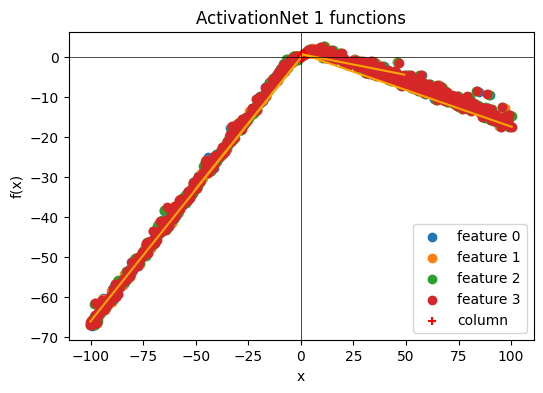

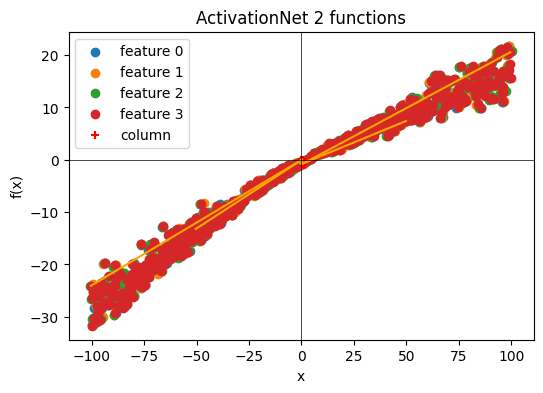

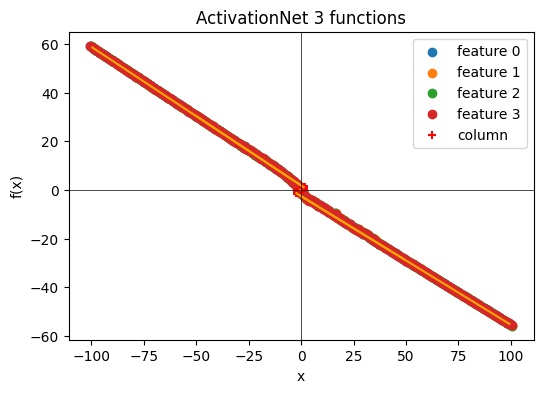

In [15]:
# (torch.rand(num_points) * 2 * x_max) - x_max for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)

def plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3]):
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]

    for i, act in enumerate(activations, 1):
        # prepare input: each feature gets the same linspace
        xs = torch.stack([
            torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)
        ], dim=1).to(device)   # [num_points, num_features]

        out, internal_out = act(xs)
        ys = out[1]
        ys = ys.detach().cpu().numpy()
        xs = xs.detach().cpu().numpy()

        int_xs, int_ys, _ = internal_out
        int_ys = int_ys.detach().cpu().numpy()[:,0]
        int_xs = int_xs.detach().cpu().numpy()[:,0]

        # new figure for each activation
        plt.figure(figsize=(6, 4))
        for k in select_features:
            if k < act.num_features:  # avoid index error
                plt.scatter(xs[:, k], ys[:, k], label=f"feature {k}")

        plt.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")
        
        # Number of points to select
        select_k_points = 5
        indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
        # Prepare x and y pairs for all segments
        gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
        gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
        # Plot all segments at once
        plt.plot(gen_data_X, gen_pred_Y, color="orange")

        plt.axhline(0, color="k", linewidth=0.5)
        plt.axvline(0, color="k", linewidth=0.5)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"ActivationNet {i} functions")
        plt.show()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
model.eval()

plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3])

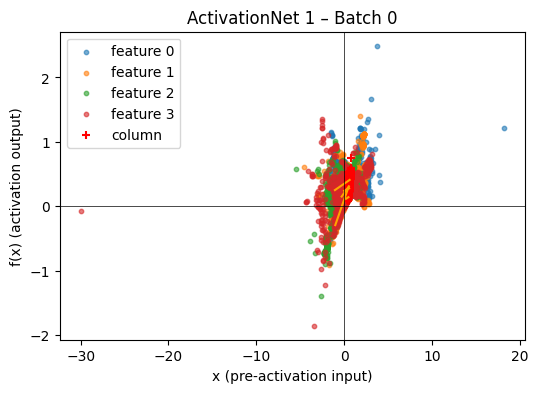

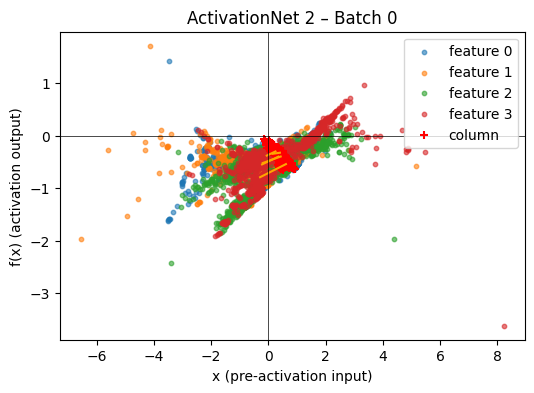

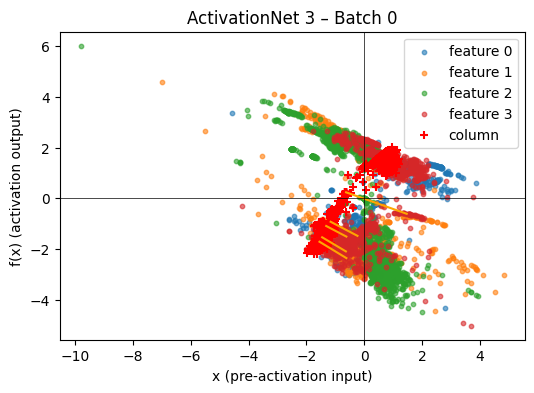

In [16]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0]):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Uses forward hooks to capture inputs and outputs of ActivationNet layers.
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = []
    for act in activations:
        hooks.append(act.register_forward_hook(hook_fn))

    # Run model on test batches
    for batch_idx, (inputs, _, _) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            plt.figure(figsize=(6, 4))
            for k in select_features:
                if k < xs.shape[1]:  # avoid index errors
                    plt.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

            plt.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

            # Number of points to select
            select_k_points = 5
            indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
            # Prepare x and y pairs for all segments
            gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
            gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
            # Plot all segments at once
            plt.plot(gen_data_X, gen_pred_Y, color="orange")
            
            plt.axhline(0, color="k", linewidth=0.5)
            plt.axvline(0, color="k", linewidth=0.5)
            plt.legend()
            plt.xlabel("x (pre-activation input)")
            plt.ylabel("f(x) (activation output)")
            plt.title(f"ActivationNet {i} – Batch {batch_idx}")
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()


if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3])

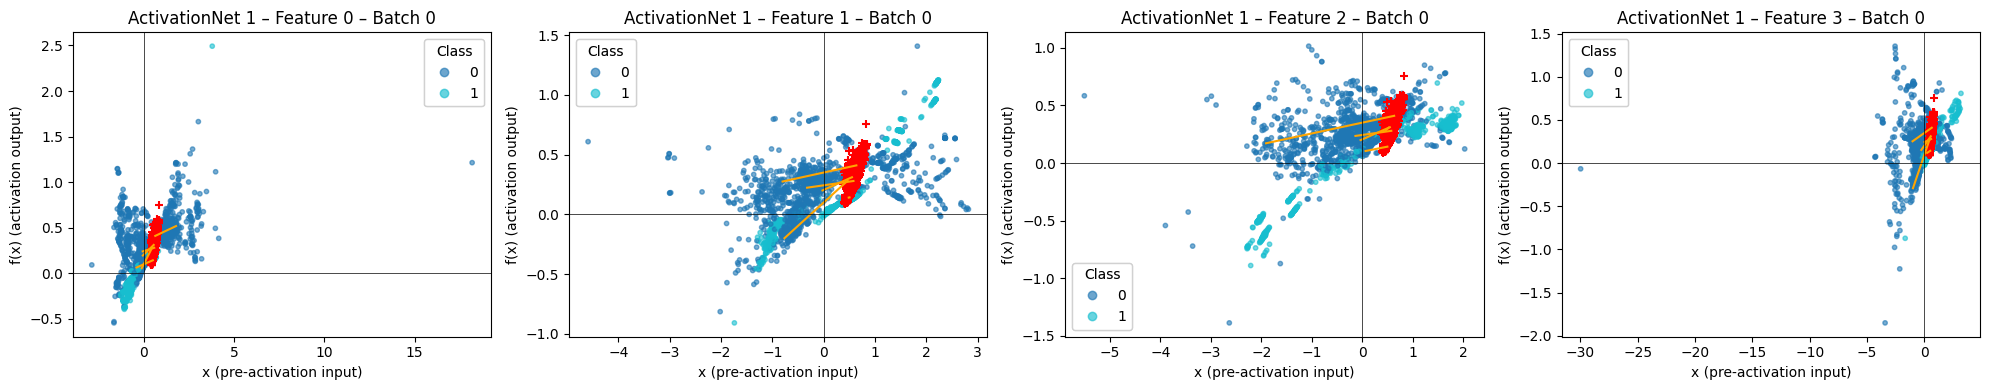

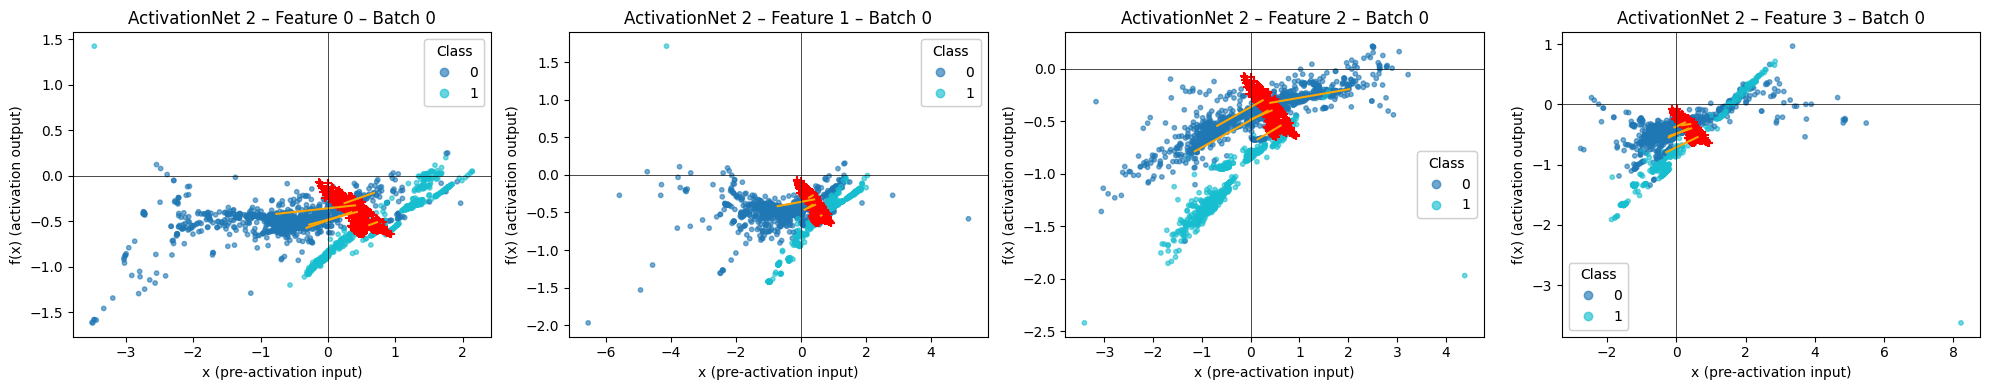

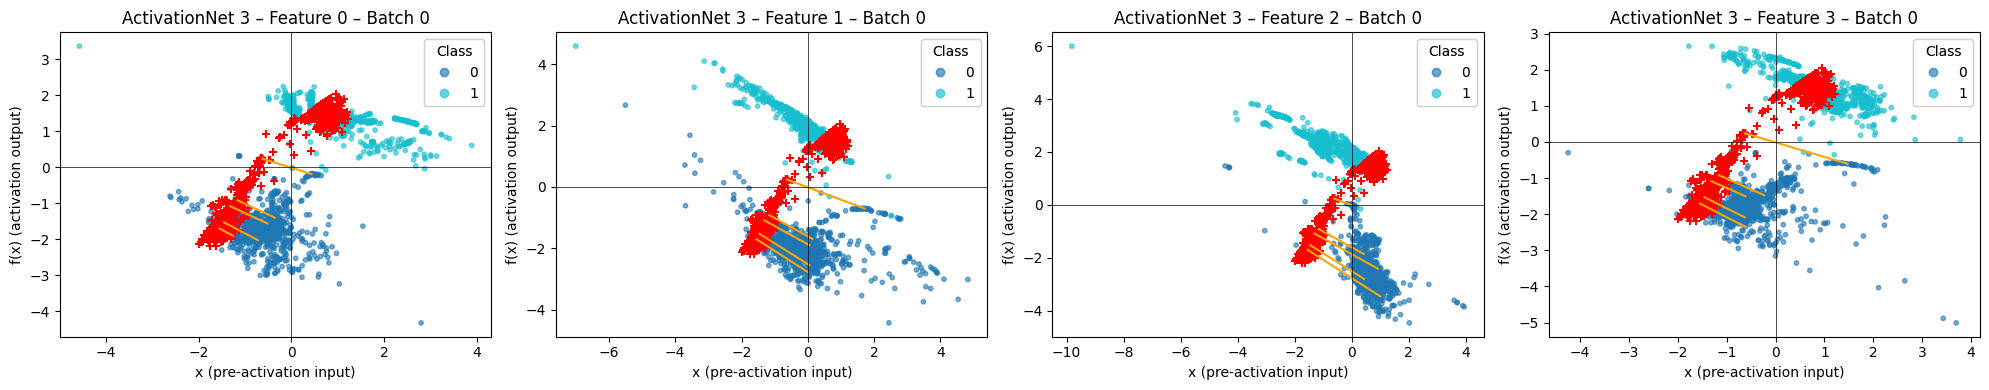

In [17]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0], color_by_class=False):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Each selected feature gets its own subplot instead of all being in one plot.

    Args:
        model: Trained KDD_Model instance
        test_loader: DataLoader with test dataset
        num_batches: Number of batches to visualize
        select_features: List of feature indices to plot
        color_by_class: If True, color points by class label from dataset
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = [act.register_forward_hook(hook_fn) for act in activations]

    # Run model on test batches
    for batch_idx, (inputs, labels, _) in enumerate(test_loader):  # assuming dataset returns (x, y, extra)
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        labels = labels.cpu().numpy() if color_by_class else None

        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            feats = [k for k in select_features if k < xs.shape[1]]
            n_feats = len(feats)
            if n_feats == 0:
                continue

            fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), squeeze=False)

            for j, k in enumerate(feats):
                ax = axes[0, j]

                if color_by_class and labels is not None:
                    scatter = ax.scatter(xs[:, k], ys[:, k], c=labels, cmap="tab10", s=10, alpha=0.6)

                    ax.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
                    ax.add_artist(legend1)
                else:
                    ax.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    ax.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    ax.legend()

                ax.axhline(0, color="k", linewidth=0.5)
                ax.axvline(0, color="k", linewidth=0.5)
                ax.set_xlabel("x (pre-activation input)")
                ax.set_ylabel("f(x) (activation output)")
                ax.set_title(f"ActivationNet {i} – Feature {k} – Batch {batch_idx}")

            plt.tight_layout()
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3], color_by_class=True)